<a href="https://colab.research.google.com/github/Polapob/Quora-text-classification/blob/main/Quora_improve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import tensorflow as tf
from torchtext import data
#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter
from textblob import TextBlob
from nltk import word_tokenize


from sklearn.metrics import f1_score
import torchtext
import os 

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from multiprocessing import  Pool
from functools import partial
import numpy as np



In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c quora-insincere-questions-classification

 57% 9.00M/15.8M [00:00<00:00, 20.1MB/s]
100% 15.8M/15.8M [00:00<00:00, 32.3MB/s]
 75% 41.0M/54.9M [00:02<00:01, 8.32MB/s]
100% 54.9M/54.9M [00:02<00:00, 26.0MB/s]
100% 4.09M/4.09M [00:00<00:00, 15.5MB/s]

100% 5.95G/5.96G [02:12<00:00, 55.7MB/s]
100% 5.96G/5.96G [02:12<00:00, 48.3MB/s]


In [4]:
! mkdir train
! mkdir test1
! mkdir submission
! mkdir embedding

In [5]:
! unzip train.csv.zip -d train
! unzip test.csv.zip -d test
! unzip sample_submission.csv.zip -d submission
! unzip embeddings.zip -d embedding

Archive:  train.csv.zip
  inflating: train/train.csv         
Archive:  test.csv.zip
  inflating: test/test.csv           
Archive:  sample_submission.csv.zip
  inflating: submission/sample_submission.csv  
Archive:  embeddings.zip
   creating: embedding/GoogleNews-vectors-negative300/
   creating: embedding/glove.840B.300d/
   creating: embedding/paragram_300_sl999/
   creating: embedding/wiki-news-300d-1M/
  inflating: embedding/glove.840B.300d/glove.840B.300d.txt  
  inflating: embedding/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  

In [6]:
! unzip embeddings.zip -d embedding

Archive:  embeddings.zip
replace embedding/glove.840B.300d/glove.840B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: embedding/wiki-news-300d-1M/wiki-news-300d-1M.vec  

In [7]:
! unzip embeddings.zip -d embedding 

Archive:  embeddings.zip
replace embedding/glove.840B.300d/glove.840B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: embedding/paragram_300_sl999/README.txt  
  inflating: embedding/paragram_300_sl999/paragram_300_sl999.txt  

In [8]:
! unzip embeddings.zip -d embedding

Archive:  embeddings.zip
replace embedding/glove.840B.300d/glove.840B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
train = pd.read_csv("train/train.csv")
test = pd.read_csv("test/test.csv")
submission = pd.read_csv("submission/sample_submission.csv")

First we split punctuation from text.

Before we split we check OOV vocab in some embedding vocab

In [3]:
def load_glove_word():    
    EMBEDDING_FILE = 'embedding/glove.840B.300d/glove.840B.300d.txt'
    dict_word = {}
    infile = open(EMBEDDING_FILE,"r")
    for line in infile:
      each_word = line.strip()[:line.strip().find(" ")]
      dict_word[each_word] = len(dict_word)
    infile.close()
    return dict_word
glove_word = load_glove_word()

def load_paragram_word():    
    EMBEDDING_FILE = 'embedding/paragram_300_sl999/paragram_300_sl999.txt'
    dict_word = {}
    infile = open( EMBEDDING_FILE , encoding="utf8", errors='ignore')
    for line in infile:
      each_word = line.strip()[:line.strip().find(" ")] 
      dict_word[each_word] = len(dict_word)
    infile.close()
    return dict_word
paragram_word = load_paragram_word()

def load_wiki_word():    
    EMBEDDING_FILE = 'embedding/wiki-news-300d-1M/wiki-news-300d-1M.vec'
    dict_word = {}
    infile = open(EMBEDDING_FILE,"r")
    count = 0
    for line in infile:
      try:
        each_word = line.strip()[:line.strip().find(" ")]
        dict_word[each_word] = len(dict_word)
      except:
        pass
    infile.close()
    return dict_word
wiki_word = load_wiki_word()

In [4]:
def sort_dictionary(list_sentence,lower):
  dictionary1 = {}
  if lower == False:
    for sentence in list_sentence:
      for word in sentence.split():
        try:
          dictionary1[word] += 1
        except:
          dictionary1[word] = 1
    word = [[word,occurrence] for word,occurrence in dictionary1.items()]
    word = sorted(word,key = lambda x:x[1],reverse=True)
    sort_dict = {}
    for i in word:
      sort_dict[i[0]] = i[1]
  elif lower == True:
    for sentence in list_sentence:
      for word in sentence.split():
        str1 = str(word).lower()
        try:
          dictionary1[str1] += 1
        except:
          dictionary1[str1] = 1
    word = [[word,occurrence] for word,occurrence in dictionary1.items()]
    word = sorted(word,key = lambda x:x[1],reverse=True)
    sort_dict = {}
    for i in word:
      sort_dict[i[0]] = i[1]
  return sort_dict
dict_word_not_lower = sort_dictionary(train.question_text.values,lower=False)
dict_word_lower = sort_dictionary(train.question_text.values,lower=True)

In [5]:
def check_OOV_vocab(dictionary,vocab_dict,embedding_dict_name):
  number_OOV = 0
  type_of_word_count = 0
  sum_word = 0
  number_in_vocab_dict = 0
  OOV_dict = {}
  for i in vocab_dict:
    try:
      if dictionary[i]:
        type_of_word_count +=1
        number_in_vocab_dict += vocab_dict[i]
    except:
      number_OOV += vocab_dict[i]
      OOV_dict[i] = vocab_dict[i]
  sum_word = number_OOV + number_in_vocab_dict
  print("Percentage type of words found in",embedding_dict_name,type_of_word_count/len(vocab_dict)*100)
  print("Percentage Word representation in" ,embedding_dict_name,"=",number_in_vocab_dict/sum_word *100)
  OOV_list = [[a,b] for a,b in OOV_dict.items()]
  OOV_list_sort = sorted(OOV_list,key = lambda x:x[1],reverse=True)
  dict_OOV = {}
  for i in OOV_list_sort:
    dict_OOV[i[0]] = i[1]
  return dict_OOV

In [43]:
glove_OOV = check_OOV_vocab(glove_word,dict_word_not_lower,"glove embedding")
print()
paragram_OOV = check_OOV_vocab(paragram_word,dict_word_not_lower,"paragram embedding")
print()
fasttext_OOV = check_OOV_vocab(wiki_word,dict_word_not_lower,"fasttext embedding")

Percentage type of words found in glove embedding 33.1586818992066
Percentage Word representation in glove embedding = 88.15871335425024

Percentage type of words found in paragram embedding 7.193267599931606
Percentage Word representation in paragram embedding = 70.77143634188691

Percentage type of words found in fasttext embedding 18.914435864730958
Percentage Word representation in fasttext embedding = 86.7637389198016


Check the target variable.

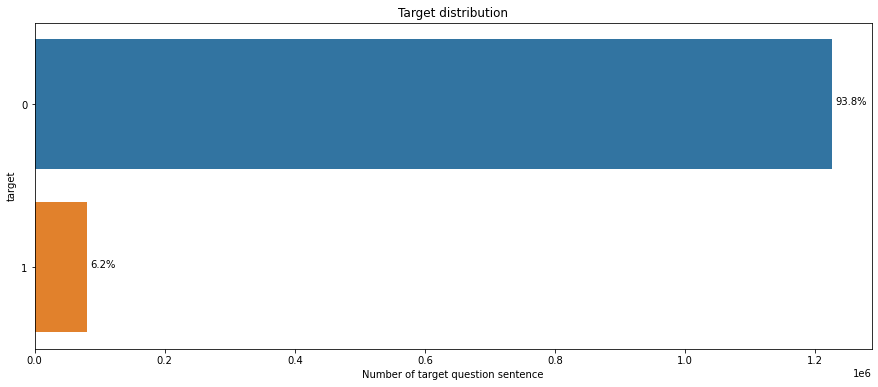

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.figure(figsize=(15,6))
ax = sns.countplot(y="target",data=train)
plt.title('Target distribution')
plt.xlabel('Number of target question sentence')

total = len(train["target"])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 5000
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

We found that this classification has imbalance data, so we will use f1-score instead of accuracy.

Check OOV in glove paragram fasttext

In [53]:
glove_OOV

NameError: ignored

In [45]:
paragram_OOV

{'What': 417802,
 'I': 306261,
 'How': 261930,
 'Why': 142291,
 'Is': 108887,
 'Can': 52698,
 'Which': 47303,
 'Do': 40041,
 'If': 34557,
 'Are': 29201,
 'Does': 23180,
 'Who': 21981,
 'Where': 19146,
 'Should': 16591,
 'India?': 16384,
 "don't": 14991,
 'Will': 14669,
 'When': 14483,
 'India': 13685,
 'it?': 12900,
 'Indian': 12895,
 "I'm": 12811,
 "What's": 12425,
 'Trump': 10132,
 'In': 10062,
 'Quora': 9988,
 'Would': 9857,
 'US': 9451,
 'do?': 8753,
 'My': 8122,
 'The': 7896,
 'life?': 7753,
 'Did': 7580,
 'Have': 7209,
 "can't": 7077,
 'American': 6675,
 'you?': 6295,
 'me?': 6202,
 'them?': 6140,
 'Has': 5844,
 "doesn't": 5733,
 'time?': 5716,
 'Chinese': 5414,
 'world?': 5386,
 'English': 5368,
 'people?': 4971,
 'why?': 4943,
 "it's": 4817,
 'Quora?': 4655,
 'As': 4643,
 'Could': 4488,
 'like?': 4487,
 'Google': 4474,
 'for?': 4450,
 'A': 4445,
 'China': 4423,
 'United': 4395,
 'Americans': 4374,
 'Was': 4338,
 'JEE': 4249,
 'work?': 4206,
 '2017?': 4050,
 'Muslims': 4021,
 'm

In [46]:
fasttext_OOV

{'India?': 16384,
 "don't": 14991,
 'it?': 12900,
 "I'm": 12811,
 "What's": 12425,
 'do?': 8753,
 'life?': 7753,
 "can't": 7077,
 'you?': 6295,
 'me?': 6202,
 'them?': 6140,
 "doesn't": 5733,
 'time?': 5716,
 'world?': 5386,
 'people?': 4971,
 'why?': 4943,
 "it's": 4817,
 'Quora?': 4655,
 'like?': 4487,
 'for?': 4450,
 'work?': 4206,
 '2017?': 4050,
 'mean?': 3971,
 '2018?': 3594,
 'country?': 3422,
 'now?': 3354,
 'this?': 3340,
 'years?': 3237,
 "didn't": 3198,
 'not?': 3114,
 'year?': 2790,
 "I've": 2774,
 'day?': 2680,
 'person?': 2617,
 'engineering?': 2599,
 'school?': 2585,
 'so,': 2562,
 'I’m': 2506,
 'money?': 2464,
 'system?': 2444,
 "you've": 2418,
 'Why?': 2405,
 'today?': 2404,
 'China?': 2392,
 'be?': 2391,
 'job?': 2354,
 'business?': 2284,
 "isn't": 2276,
 'company?': 2240,
 '"The': 2239,
 'online?': 2200,
 'him?': 2196,
 'exam?': 2175,
 'US?': 2114,
 'don’t': 2089,
 'Canada?': 2064,
 'countries?': 2055,
 'out?': 2012,
 'that?': 1989,
 "you're": 1981,
 'future?': 1952,

OOV in glove and fasttext have the same pattern which have punctuations- most of them are "?" and case sensitive. But OOV paragram words have case unsensitive.

So we will lower case in paragram before check in word_embedding.

In [47]:
paragram_OOV = check_OOV_vocab(paragram_word,dict_word_lower,"paragram embedding")

Percentage type of words found in paragram embedding 9.906476081807345
Percentage Word representation in paragram embedding = 85.70376535430096


In [48]:
paragram_OOV

{'india?': 16394,
 "don't": 15654,
 "what's": 13369,
 'it?': 13158,
 "i'm": 12814,
 'quora': 10001,
 'do?': 8766,
 'life?': 7791,
 'why?': 7369,
 "can't": 7352,
 'you?': 6314,
 'me?': 6241,
 'them?': 6141,
 "doesn't": 6053,
 "it's": 5761,
 'time?': 5742,
 'world?': 5525,
 'people?': 5008,
 'quora?': 4657,
 'like?': 4490,
 'for?': 4450,
 'jee': 4397,
 'work?': 4219,
 '2017?': 4050,
 'mean?': 3980,
 '2018?': 3594,
 "isn't": 3509,
 'country?': 3444,
 'now?': 3371,
 'this?': 3345,
 "didn't": 3284,
 'years?': 3244,
 'not?': 3125,
 'us?': 3083,
 'engineering?': 2965,
 'school?': 2902,
 'day?': 2847,
 'year?': 2821,
 "i've": 2774,
 'so,': 2748,
 '"the': 2666,
 'person?': 2622,
 'system?': 2542,
 'university?': 2520,
 'i’m': 2507,
 'money?': 2479,
 "you've": 2448,
 'be?': 2421,
 'today?': 2409,
 'china?': 2392,
 'job?': 2355,
 'company?': 2347,
 'business?': 2346,
 'exam?': 2259,
 'online?': 2230,
 'him?': 2217,
 'don’t': 2189,
 'college?': 2172,
 'neet': 2115,
 "you're": 2070,
 'canada?': 206

Paragram word embedding representation by case unsensitive is look much better than case sensitive word.

We have 2 case to find the best way to deal with it.

1.   We clean the punctuation and number first and we clean missspell text.
2.   We clean missspell text first and We clean the punctuation and number second.

We will choose one of two cases from percentage in Word represenatation in three word embedding.



In [6]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';',  '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
        x = re.sub('[0-9]{1}', '#', x)
    return x
clean_train = train.copy()
clean_train["question_text"]= clean_train.question_text.apply(lambda x: clean_text(x))
clean_train["question_text"]= clean_train.question_text.apply(lambda x: clean_numbers(x))

In [7]:
missspell_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", 
                "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
                "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
                "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", 
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                "y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center',
                'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2',
                'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much',
                'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis',
                'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota',
                'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
                'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

In [8]:
dict1 = sort_dictionary(clean_train["question_text"].values,lower=False)

In [9]:
list2 = []
for i in range(2):
  print("Before improvement")
  print("Len missspell dict = " + str(len(missspell_dict)))
  for i in missspell_dict:
    try:
      str1 = i[0].upper() +i[1:]
      if str1 in dict1:
        #print(str1 + "doesn't full clean.")
        r = True
      list2.append(str1.lower())
    except:
      pass
  lista = list2[:len(list2)-1]
  for i in lista:
    try:
      str1 = i[0].upper() +i[1:]    
      str2 = missspell_dict[i][0].upper() + missspell_dict[i][1:]
      missspell_dict[str1] = str2 
    except:
      pass
  print("After improvement")
  print("Len missspell dict = " + str(len(missspell_dict)))
  print()

Before improvement
Len missspell dict = 162
After improvement
Len missspell dict = 303

Before improvement
Len missspell dict = 303
After improvement
Len missspell dict = 304



In [12]:
for i in lista:
    try:
      str1 = i[0].upper() +i[1:]    
      str2 = missspell_dict[i][0].upper() + missspell_dict[i][1:]
      missspell_dict[str1] = str2 
    except:
      print(str1,str2)
      pass

Qoura Youtube 
Whta Salary
Doi Why do
Thebest Why do
Etherium Penis
Qoura Youtube 
Whta Salary
Doi Why do
Thebest Why do
Etherium Penis


In [10]:
def check_missspell(text):
  str_text = str(text)
  for i in missspell_dict:
    if i in str_text:
      str_text = str_text.replace(i,missspell_dict[i])
  return str_text
clean_train["question_text"] = clean_train["question_text"].apply(lambda x: check_missspell(x))

In [14]:
clean_train2 = train.copy()

clean_train2["question_text"] = clean_train2["question_text"].apply(lambda x: check_missspell(x))

clean_train2["question_text"]= clean_train2.question_text.apply(lambda x: clean_text(x))
clean_train2["question_text"]= clean_train2.question_text.apply(lambda x: clean_numbers(x))

In [15]:
dict_word_not_lower = sort_dictionary(clean_train.question_text.values,False)
dict_word_lower = sort_dictionary(clean_train.question_text,True)

print("Case1")
print()
glove_OOV_case1 = check_OOV_vocab(glove_word,dict_word_not_lower,"glove embedding")
print()
paragram_OOV_case1 = check_OOV_vocab(paragram_word,dict_word_lower,"paragram embedding")
print()
fasttext_OOV_case1 = check_OOV_vocab(wiki_word,dict_word_not_lower,"fasttext embedding")

Case1

Percentage type of words found in glove embedding 67.99589508952111
Percentage Word representation in glove embedding = 99.09594586901753

Percentage type of words found in paragram embedding 20.402380975845315
Percentage Word representation in paragram embedding = 97.05003091269909

Percentage type of words found in fasttext embedding 38.99218769013605
Percentage Word representation in fasttext embedding = 97.59393848638216


In [16]:
glove_OOV_case1

{'##th': 5936,
 "Trump's": 1573,
 'WW#': 1353,
 '##k': 1087,
 '##s': 1086,
 '####s': 1074,
 '#nd': 1040,
 'Quorans': 852,
 "today's": 788,
 "someone's": 786,
 "one's": 692,
 "India's": 672,
 "people's": 644,
 'Brexit': 490,
 'cryptocurrencies': 480,
 "##'s": 477,
 "women's": 475,
 "world's": 472,
 "#'#": 463,
 "person's": 452,
 'PS#': 448,
 'S#': 418,
 '###k': 411,
 '##st': 402,
 "China's": 401,
 'F#': 383,
 'Redmi': 377,
 'i#': 368,
 "country's": 355,
 "####'s": 353,
 'B#': 342,
 'A#': 319,
 "master's": 318,
 "America's": 310,
 "men's": 305,
 'H#B': 294,
 "friend's": 261,
 'B#B': 256,
 "Obama's": 253,
 "Quora's": 252,
 "bachelor's": 250,
 "God's": 245,
 "man's": 242,
 'H#': 241,
 "Earth's": 240,
 'G#': 230,
 "woman's": 223,
 "company's": 223,
 'CO#': 223,
 "else's": 214,
 '##m': 206,
 "children's": 200,
 "father's": 198,
 "Master's": 197,
 "child's": 187,
 "mother's": 184,
 '##K': 183,
 "Modi's": 178,
 "girl's": 177,
 "dog's": 171,
 "McDonald's": 167,
 '##kg': 166,
 "'The": 164,
 '##m

In [17]:
dict_word_not_lower2 = sort_dictionary(clean_train2.question_text.values,False)
dict_word_lower2 = sort_dictionary(clean_train2.question_text,True)

print("Case2")
print()

glove_OOV_case2 = check_OOV_vocab(glove_word,dict_word_not_lower2,"glove embedding")
print()
paragram_OOV_case2 = check_OOV_vocab(paragram_word,dict_word_lower2,"paragram embedding")
print()
fasttext_OOV_case2 = check_OOV_vocab(wiki_word,dict_word_not_lower2,"fasttext embedding")

Case2

Percentage type of words found in glove embedding 67.99589508952111
Percentage Word representation in glove embedding = 99.09607825745049

Percentage type of words found in paragram embedding 20.401888224221697
Percentage Word representation in paragram embedding = 97.04998854840055

Percentage type of words found in fasttext embedding 38.99178206657094
Percentage Word representation in fasttext embedding = 97.59376588249933


Case 1 and Case 2 have approximately the same in performance.

First we will do word cloud and then, we will do OOV word cloud.

In [18]:
Normal_question_sentence = clean_train[clean_train.target==0].question_text.values
Negative_question_sentence = clean_train[clean_train.target==1].question_text.values

In [19]:
Normal_question_word = ""
Negative_question_word = ""
for word in Normal_question_sentence:
  Normal_question_word += word + " "
for word in Negative_question_sentence:
  Negative_question_word += word + " "

In [63]:
pip install WordCloud

In [20]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
stopwords.add("will")

We will include stopwords to visualize our word cloud better.

In [21]:
Normal_wordcloud = WordCloud(width = 800, height = 800, background_color ='white',stopwords = stopwords).generate(Normal_question_word)
Negative_wordcloud = WordCloud(width = 800, height = 800, background_color ='white',stopwords = stopwords).generate(Negative_question_word)

In [22]:
import matplotlib.pyplot as plt

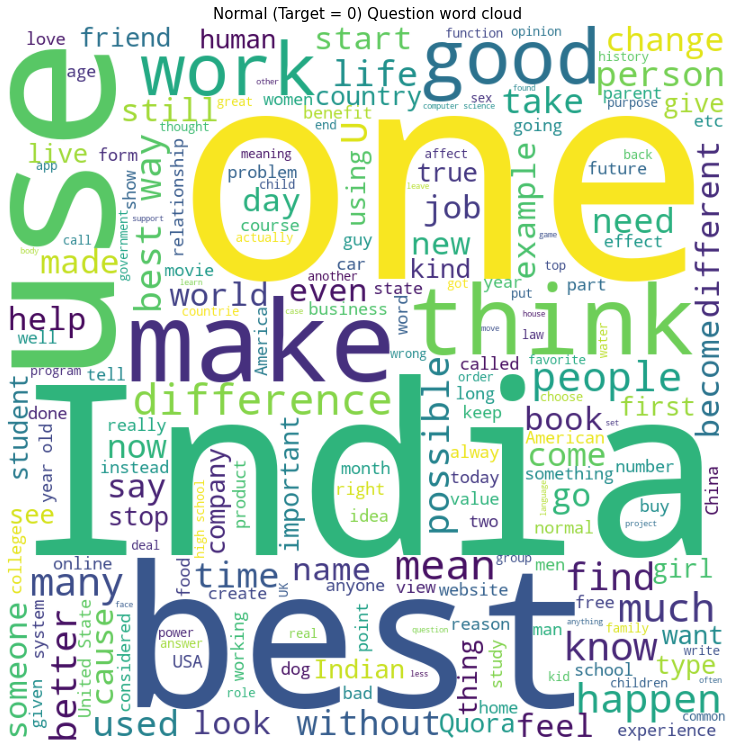

In [23]:
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue') 
plt.imshow(Normal_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Normal (Target = 0) Question word cloud",fontdict={"fontsize":15})
plt.show()

An interesting thing in normal word cloud is India. The word colud is varies on difference question.

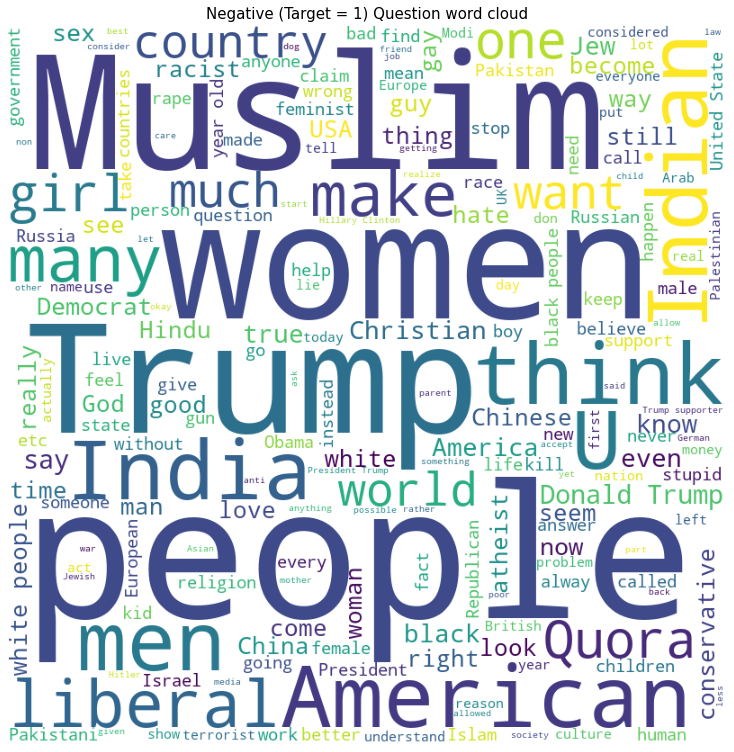

In [24]:
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue') 
plt.imshow(Negative_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Negative (Target = 1) Question word cloud",fontdict={"fontsize":15})
plt.show()

From word cloud we found that lot of bad questions is about Nationality,Sex, Political views and Skin.

And we will do Unigram, Bigram and Trigram with normal and negative question.

In [25]:
Normal_question_word[:1000]

'How did Quebec nationalists see their province as a nation in the ####s ?  Do you have an adopted dog ,  how would you encourage people to adopt and not shop ?  Why does velocity affect time ?  Does velocity affect space geometry ?  How did Otto von Guericke used the Magdeburg hemispheres ?  Can I convert montra helicon D to a mountain bike by just changing the tyres ?  Is Gaza slowly becoming Auschwitz ,  Dachau or Treblinka for Palestinians ?  Why does Quora automatically ban conservative opinions when reported ,  but does not do the same for liberal views ?  Is it crazy if I wash or wipe my groceries off ?  Germs are everywhere .  Is there such a thing as dressing moderately ,  and if so ,  how is that different than dressing modestly ?  Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved ,  completely disregarding their feelings / lives so you get to have something go your way and feel temporarily at ease .  How did things cha

In [26]:
Negative_question_word[:1000]

"Has the United States become the largest dictatorship in the world ?  Which babies are more sweeter to their parents ?  Dark skin babies or light skin babies ?  If blacks support school choice and mandatory sentencing for criminals why do not they vote Republican ?  I am gay boy and I love my cousin  ( boy )  .  He is sexy ,  but I dont know what to do .  He is hot ,  and I want to see his di *  *  .  What should I do ?  Which races have the smallest penis ?  Why do females find penises ugly ?  How do I marry an American woman for a Green Card ?  How much do they charge ?  Why do Europeans say they are the superior race ,  when in fact it took them over # , ### years until mid ##th century to surpass China's largest economy ?  Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission ?  In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually restricted the ability of states to make their own l

In [27]:
normal_word_dictionary = {}
negative_word_dictionary = {}

for i in Normal_question_word.split():
  try:
    normal_word_dictionary[i] +=1
  except:
    normal_word_dictionary[i] = 1

for i in Negative_question_word.split():
  try:
    negative_word_dictionary[i] +=1
  except:
    negative_word_dictionary[i] = 1

sort_dict1 = [[i,j] for i,j in normal_word_dictionary.items()]
normal_word_list = sorted(sort_dict1,key=lambda x:x[1],reverse=True)

sort_dict2 = [[i,j] for i,j in negative_word_dictionary.items()]
negative_word_list = sorted(sort_dict2,key = lambda x:x[1],reverse=True)

normal_word_dictionary = {}
negative_word_dictionary = {}

for i in normal_word_list:
  normal_word_dictionary[i[0]] = [i[1]]
for j in negative_word_list:
  negative_word_dictionary[j[0]] = [j[1]]

In [28]:
normal_dict = sort_dictionary(Normal_question_sentence,False)
negative_dict = sort_dictionary(Negative_question_sentence,False)

In [29]:
normal_word_df = pd.DataFrame(normal_word_dictionary).transpose()
negative_word_df = pd.DataFrame(negative_word_dictionary).transpose()

In [30]:
normal_word_df.rename(columns={0:"Occurrence"},inplace=True)
negative_word_df.rename(columns={0:"Occurrence"},inplace=True)

In [31]:
normal_word_df_top_1000 = normal_word_df.iloc[:1000,:]
negative_word_df_top_1000 = negative_word_df.iloc[:1000,:]

In [32]:
STOPWORDS_new = STOPWORDS.copy()
STOPWORDS_new

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '

In [33]:
for i in STOPWORDS:
  str_to_add = i[0].upper()+i[1:]
  STOPWORDS_new.add(str_to_add)

In [34]:
STOPWORDS_new

{'A',
 'About',
 'Above',
 'After',
 'Again',
 'Against',
 'All',
 'Also',
 'Am',
 'An',
 'And',
 'Any',
 'Are',
 "Aren't",
 'As',
 'At',
 'Be',
 'Because',
 'Been',
 'Before',
 'Being',
 'Below',
 'Between',
 'Both',
 'But',
 'By',
 'Can',
 "Can't",
 'Cannot',
 'Com',
 'Could',
 "Couldn't",
 'Did',
 "Didn't",
 'Do',
 'Does',
 "Doesn't",
 'Doing',
 "Don't",
 'Down',
 'During',
 'Each',
 'Else',
 'Ever',
 'Few',
 'For',
 'From',
 'Further',
 'Get',
 'Had',
 "Hadn't",
 'Has',
 "Hasn't",
 'Have',
 "Haven't",
 'Having',
 'He',
 "He'd",
 "He'll",
 "He's",
 'Her',
 'Here',
 "Here's",
 'Hers',
 'Herself',
 'Him',
 'Himself',
 'His',
 'How',
 "How's",
 'However',
 'Http',
 'I',
 "I'd",
 "I'll",
 "I'm",
 "I've",
 'If',
 'In',
 'Into',
 'Is',
 "Isn't",
 'It',
 "It's",
 'Its',
 'Itself',
 'Just',
 'K',
 "Let's",
 'Like',
 'Me',
 'More',
 'Most',
 "Mustn't",
 'My',
 'Myself',
 'No',
 'Nor',
 'Not',
 'Of',
 'Off',
 'On',
 'Once',
 'Only',
 'Or',
 'Other',
 'Otherwise',
 'Ought',
 'Our',
 'Ours',
 '

In [35]:
puncts

[',',
 '.',
 '"',
 ':',
 ')',
 '(',
 '-',
 '!',
 '?',
 '|',
 ';',
 '$',
 '&',
 '/',
 '[',
 ']',
 '>',
 '%',
 '=',
 '#',
 '*',
 '+',
 '\\',
 '•',
 '~',
 '@',
 '£',
 '·',
 '_',
 '{',
 '}',
 '©',
 '^',
 '®',
 '`',
 '<',
 '→',
 '°',
 '€',
 '™',
 '›',
 '♥',
 '←',
 '×',
 '§',
 '″',
 '′',
 'Â',
 '█',
 '½',
 'à',
 '…',
 '“',
 '★',
 '”',
 '–',
 '●',
 'â',
 '►',
 '−',
 '¢',
 '²',
 '¬',
 '░',
 '¶',
 '↑',
 '±',
 '¿',
 '▾',
 '═',
 '¦',
 '║',
 '―',
 '¥',
 '▓',
 '—',
 '‹',
 '─',
 '▒',
 '：',
 '¼',
 '⊕',
 '▼',
 '▪',
 '†',
 '■',
 '’',
 '▀',
 '¨',
 '▄',
 '♫',
 '☆',
 'é',
 '¯',
 '♦',
 '¤',
 '▲',
 'è',
 '¸',
 '¾',
 'Ã',
 '⋅',
 '‘',
 '∞',
 '∙',
 '）',
 '↓',
 '、',
 '│',
 '（',
 '»',
 '，',
 '♪',
 '╩',
 '╚',
 '³',
 '・',
 '╦',
 '╣',
 '╔',
 '╗',
 '▬',
 '❤',
 'ï',
 'Ø',
 '¹',
 '≤',
 '‡',
 '√']

In [36]:
normal_word_dictionary_modify = {}
negative_word_dictionary_modify = {}
for i in normal_word_dictionary:
  if i not in puncts:
    if i not in STOPWORDS_new:
      if "#" not in i:
        normal_word_dictionary_modify[i] = normal_word_dictionary[i]

for i in negative_word_dictionary:
  if i not in puncts:
    if i not in STOPWORDS_new:
      if "#" not in i:
        negative_word_dictionary_modify[i] = negative_word_dictionary[i]

In [37]:
normal_word_df = pd.DataFrame(normal_word_dictionary_modify).transpose()
negative_word_df = pd.DataFrame(negative_word_dictionary_modify).transpose()

normal_word_df.rename(columns={0:"Occurrence"},inplace=True)
negative_word_df.rename(columns={0:"Occurrence"},inplace=True)

normal_word_df_top_1000 = normal_word_df.iloc[:1000,:]
negative_word_df_top_1000 = negative_word_df.iloc[:1000,:]

Doing unigram, bigram, trigram with normal and negative question with clean text

Check unigram with normal question and negative question.

In [38]:
normal_word_df_top_1000["word"] = normal_word_df_top_1000.index
negative_word_df_top_1000["word"] = negative_word_df_top_1000.index

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
import seaborn as sns

Text(0.5, 1.0, 'Unigram with normal question')

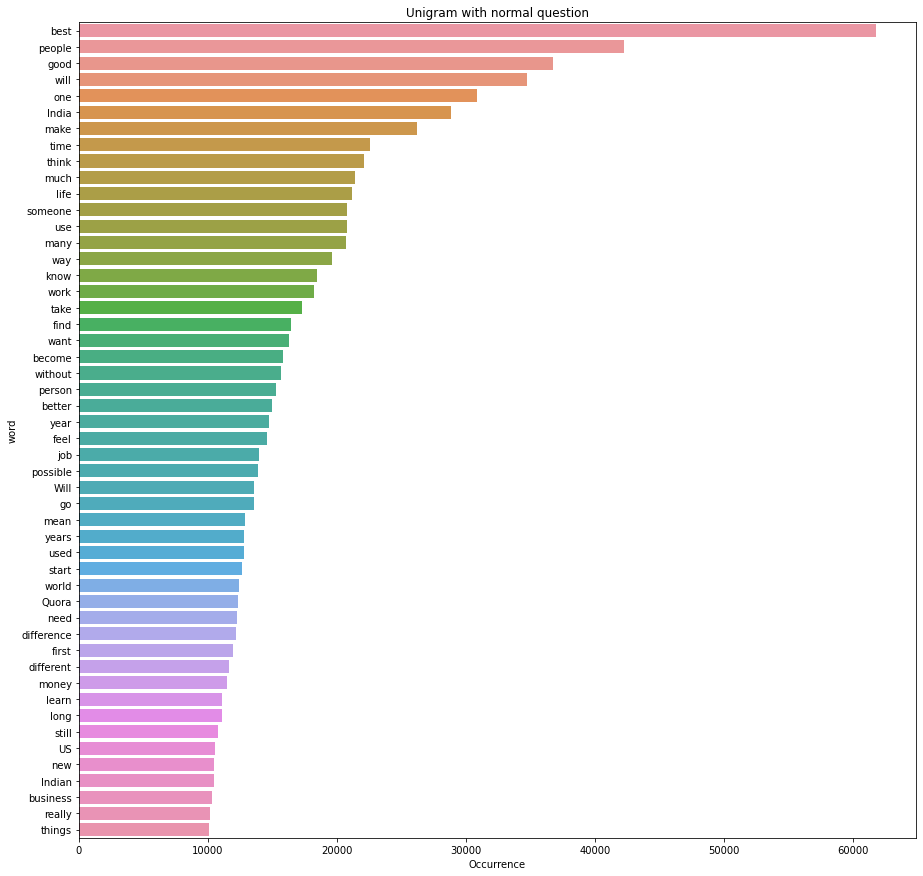

In [40]:
plt.figure(figsize=(15,15))
sns.barplot(data=normal_word_df_top_1000.iloc[:50,:],y="word",x="Occurrence")
plt.title("Unigram with normal question")
plt.show()

Text(0.5, 1.0, 'Unigram with negative question')

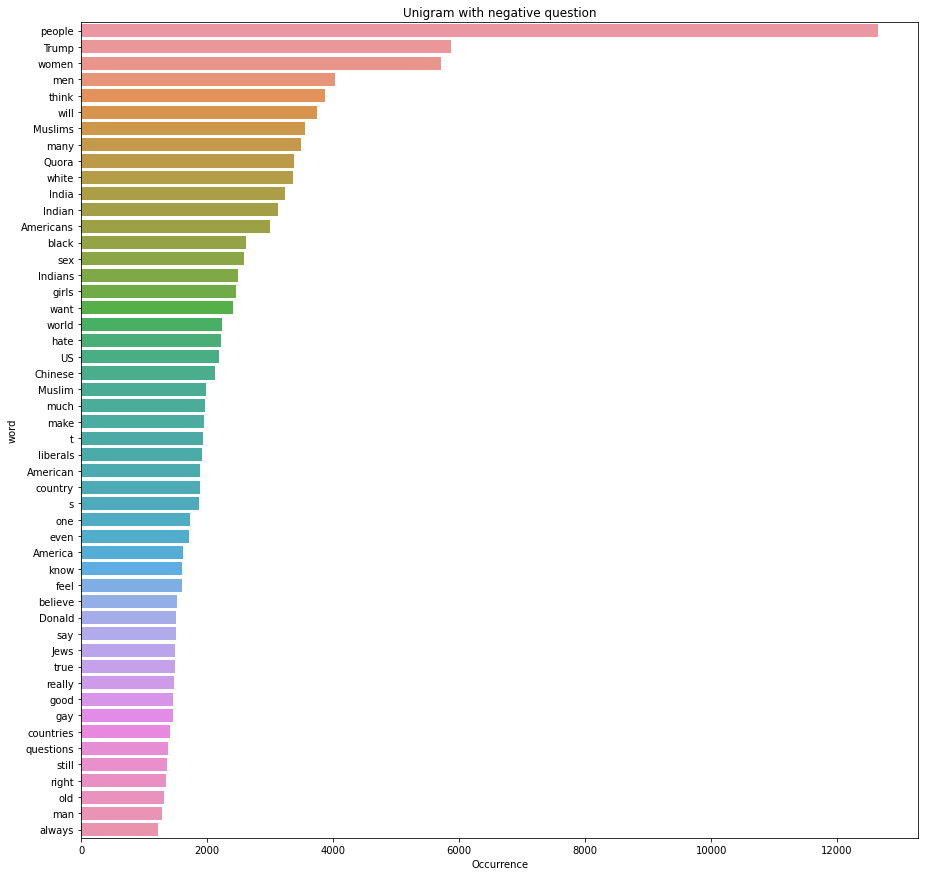

In [41]:
plt.figure(figsize=(15,15))
sns.barplot(data=negative_word_df_top_1000.iloc[:50,:],y="word",x="Occurrence")
plt.title("Unigram with negative question")
plt.show()

Bigram in Normal and Negative question.

In [42]:
Normal_question_sentence

array(['How did Quebec nationalists see their province as a nation in the ####s ? ',
       'Do you have an adopted dog ,  how would you encourage people to adopt and not shop ? ',
       'Why does velocity affect time ?  Does velocity affect space geometry ? ',
       ..., 'Is foam insulation toxic ? ',
       'How can one start a research project based on biochemistry at UG level ? ',
       'Who wins in a battle between a Wolverine and a Puma ? '],
      dtype=object)

In [43]:
Bigram_normal_dict = {}
Bigram_negative_dict = {}

for i in Normal_question_sentence:
  list_word_in_sentence = i.split()
  for i in range(len(list_word_in_sentence)-1):
    Word_visualize = list_word_in_sentence[i] +" " +list_word_in_sentence[i+1]
    try:
      Bigram_normal_dict[Word_visualize] +=1
    except:
      Bigram_normal_dict[Word_visualize] = 1


In [44]:
for i in Negative_question_sentence:
  list_word_in_sentence = i.split()
  for i in range(len(list_word_in_sentence)-1):
    Word_visualize = list_word_in_sentence[i] +" "+ list_word_in_sentence[i+1]
    try:
      Bigram_negative_dict[Word_visualize] +=1
    except:
      Word_visualize = list_word_in_sentence[i] +" "+ list_word_in_sentence[i+1]
      Bigram_negative_dict[Word_visualize] = 1
      

In [45]:
sort_bigram_normal = sorted([[i,j] for i,j in Bigram_normal_dict.items()],key=lambda x:x[1],reverse = True)
sort_bigram_negative = sorted([[i,j] for i,j in Bigram_negative_dict.items()],key=lambda x:x[1],reverse = True)

In [46]:
sort_bigram_normal_df = pd.DataFrame(sort_bigram_normal)
sort_bigram_normal_df.rename(columns={0:"Bigram",1:"Occurrence"},inplace=True)
sort_bigram_negative_df = pd.DataFrame(sort_bigram_negative)
sort_bigram_negative_df.rename(columns={0:"Bigram",1:"Occurrence"},inplace=True)

Visualize Bigram

Text(0.5, 1.0, 'Bigram of normal question')

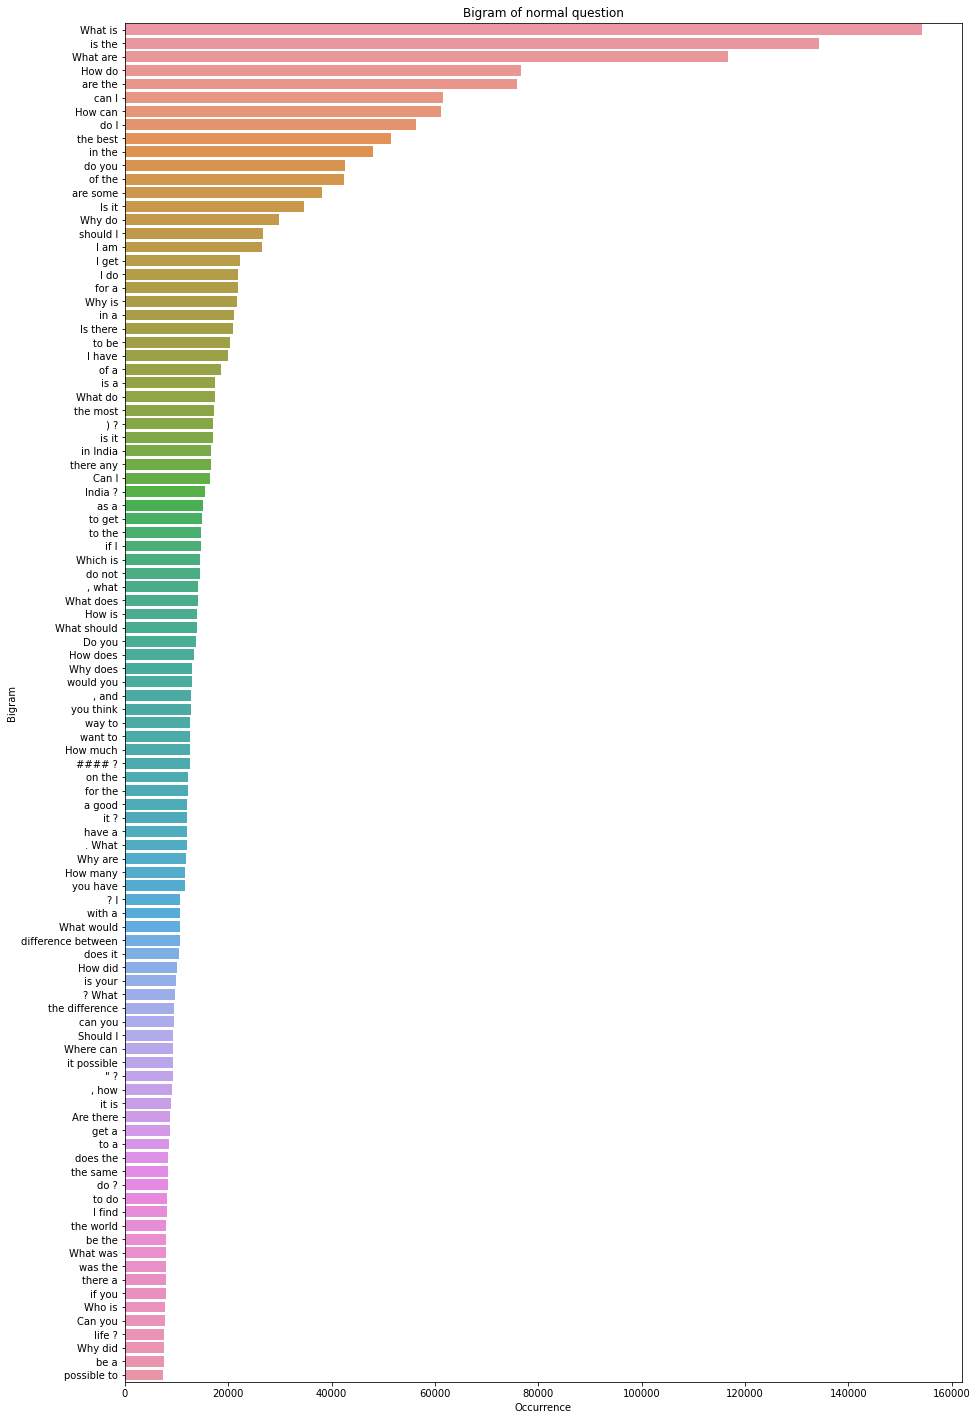

In [47]:
plt.figure(figsize=(15,25))
sns.barplot(data=sort_bigram_normal_df.iloc[:100,:],y="Bigram",x="Occurrence")
plt.title("Bigram of normal question")
plt.show()

Text(0.5, 1.0, 'Bigram of negative question')

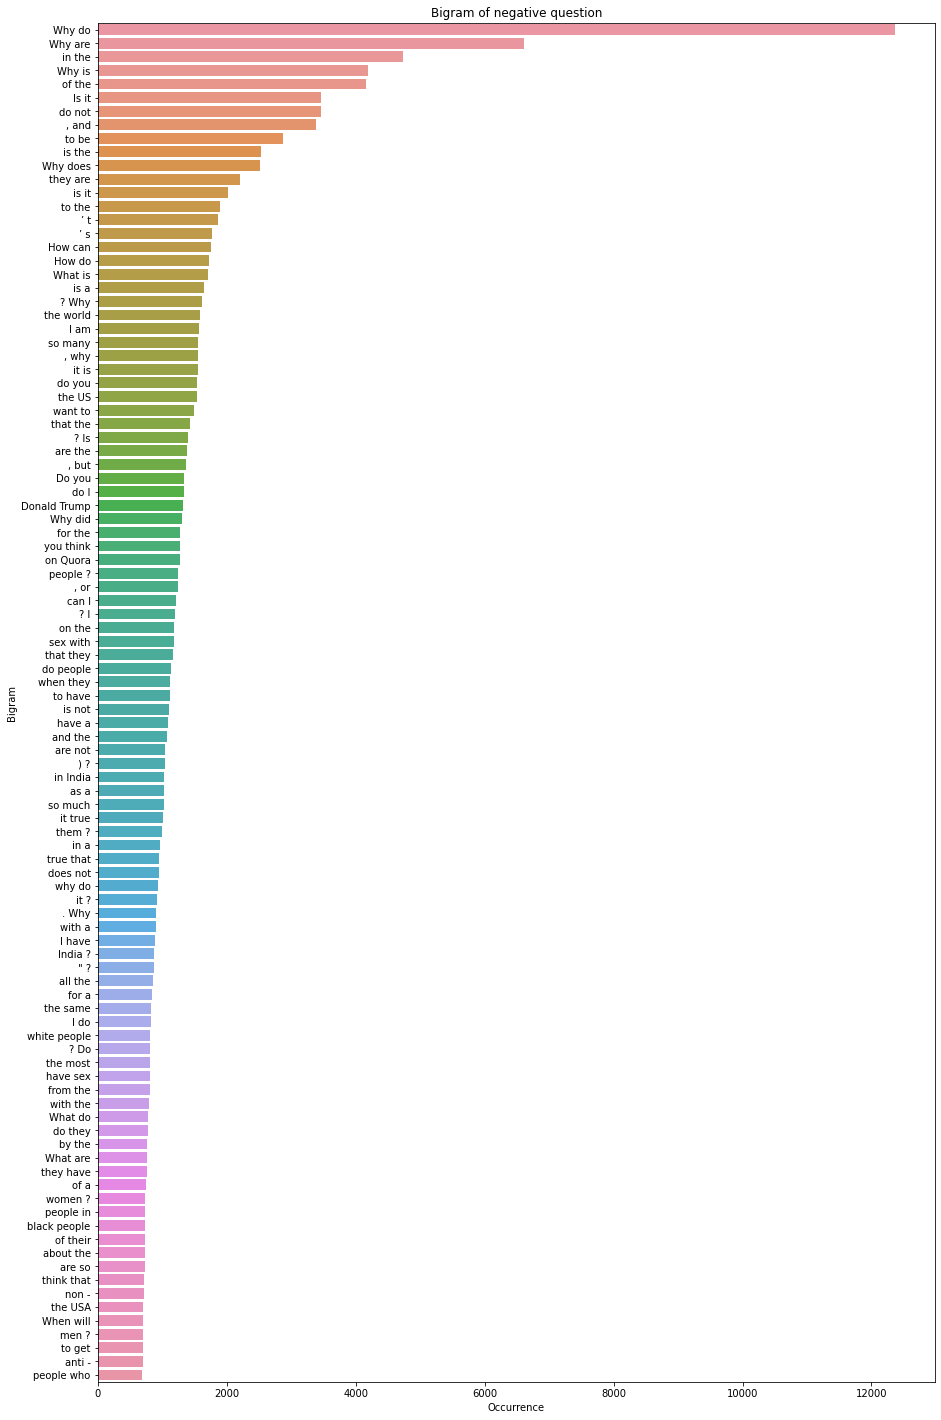

In [48]:
plt.figure(figsize=(15,25))
sns.barplot(data=sort_bigram_negative_df.iloc[:100,:],y="Bigram",x="Occurrence")
plt.title("Bigram of negative question")
plt.show()

Final Visualization by Doing trigram.

In [49]:
Trigram_normal_dict = {}
Trigram_negative_dict = {}

for i in Normal_question_sentence:
  list_word_in_sentence = i.split()
  for i in range(len(list_word_in_sentence)-2):
    Word_visualize = list_word_in_sentence[i] +" " +list_word_in_sentence[i+1] +" " +list_word_in_sentence[i+2]
    try:
      Trigram_normal_dict[Word_visualize] +=1
    except:
      Trigram_normal_dict[Word_visualize] = 1

for i in Negative_question_sentence:
  list_word_in_sentence = i.split()
  for i in range(len(list_word_in_sentence)-2):
    Word_visualize = list_word_in_sentence[i] +" " +list_word_in_sentence[i+1] +" "+list_word_in_sentence[i+2]
    try:
      Trigram_negative_dict[Word_visualize] +=1
    except:
      Trigram_negative_dict[Word_visualize] = 1


In [50]:
sort_trigram_normal = sorted([[i,j] for i,j in Trigram_normal_dict.items()],key=lambda x:x[1],reverse = True)
sort_trigram_negative = sorted([[i,j] for i,j in Trigram_negative_dict.items()],key=lambda x:x[1],reverse = True)

In [51]:
sort_trigram_normal_df = pd.DataFrame(sort_trigram_normal)
sort_trigram_normal_df.rename(columns={0:"Trigram",1:"Occurrence"},inplace=True)
sort_trigram_negative_df = pd.DataFrame(sort_trigram_negative)
sort_trigram_negative_df.rename(columns={0:"Trigram",1:"Occurrence"},inplace=True)

Text(0.5, 1.0, 'Trigram for normal question')

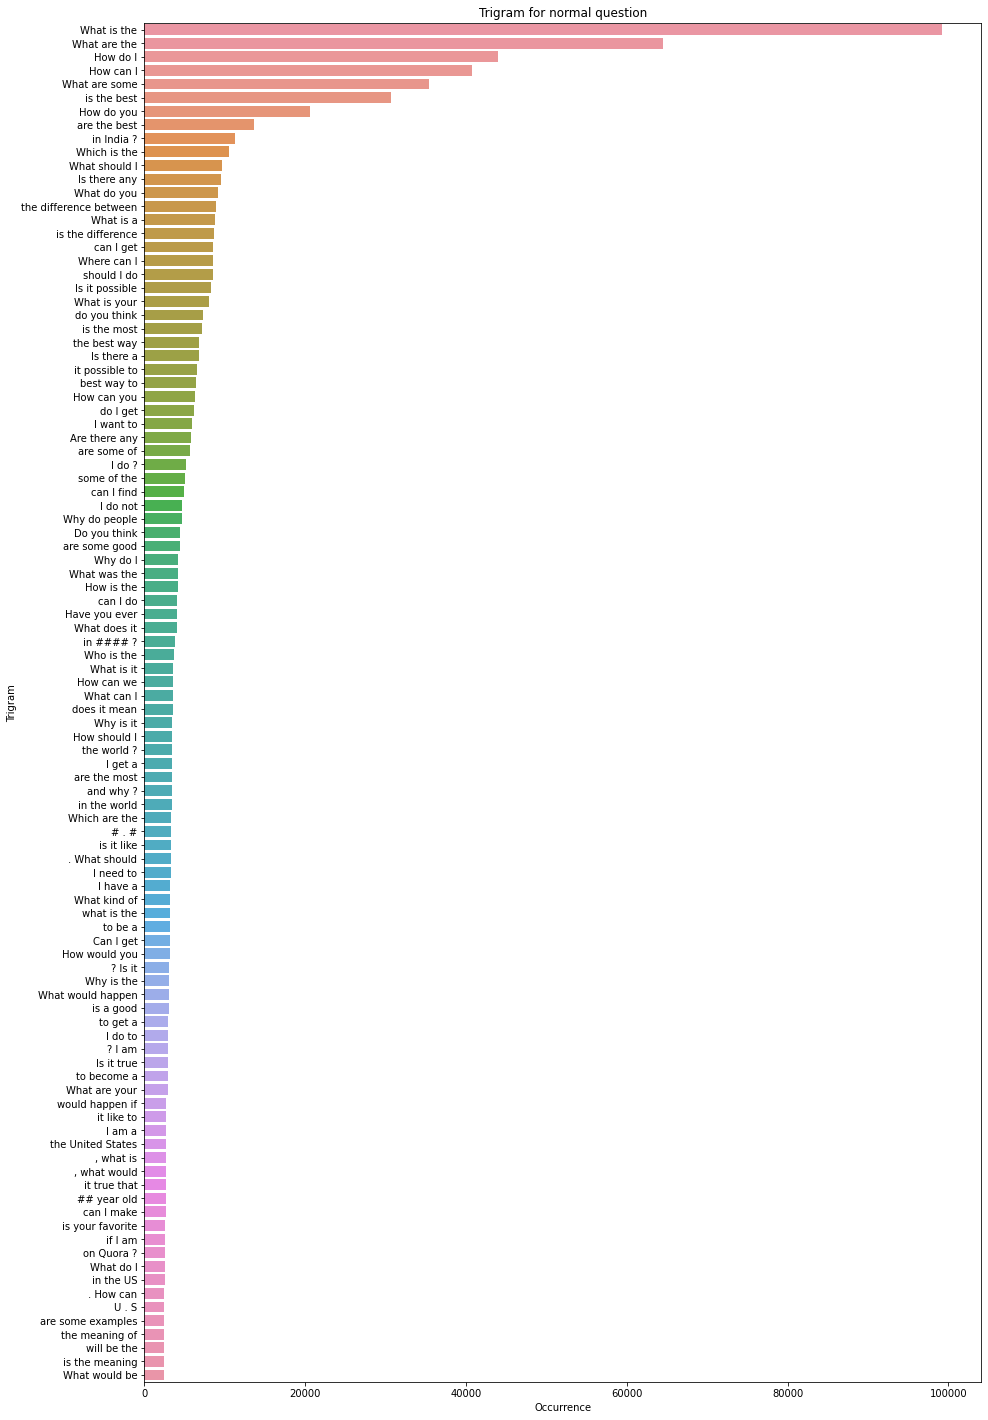

In [52]:
plt.figure(figsize=(15,25))
sns.barplot(data=sort_trigram_normal_df.iloc[:100],x="Occurrence",y="Trigram")
plt.title("Trigram for normal question")
plt.show()

Text(0.5, 1.0, 'Trigram for bad question')

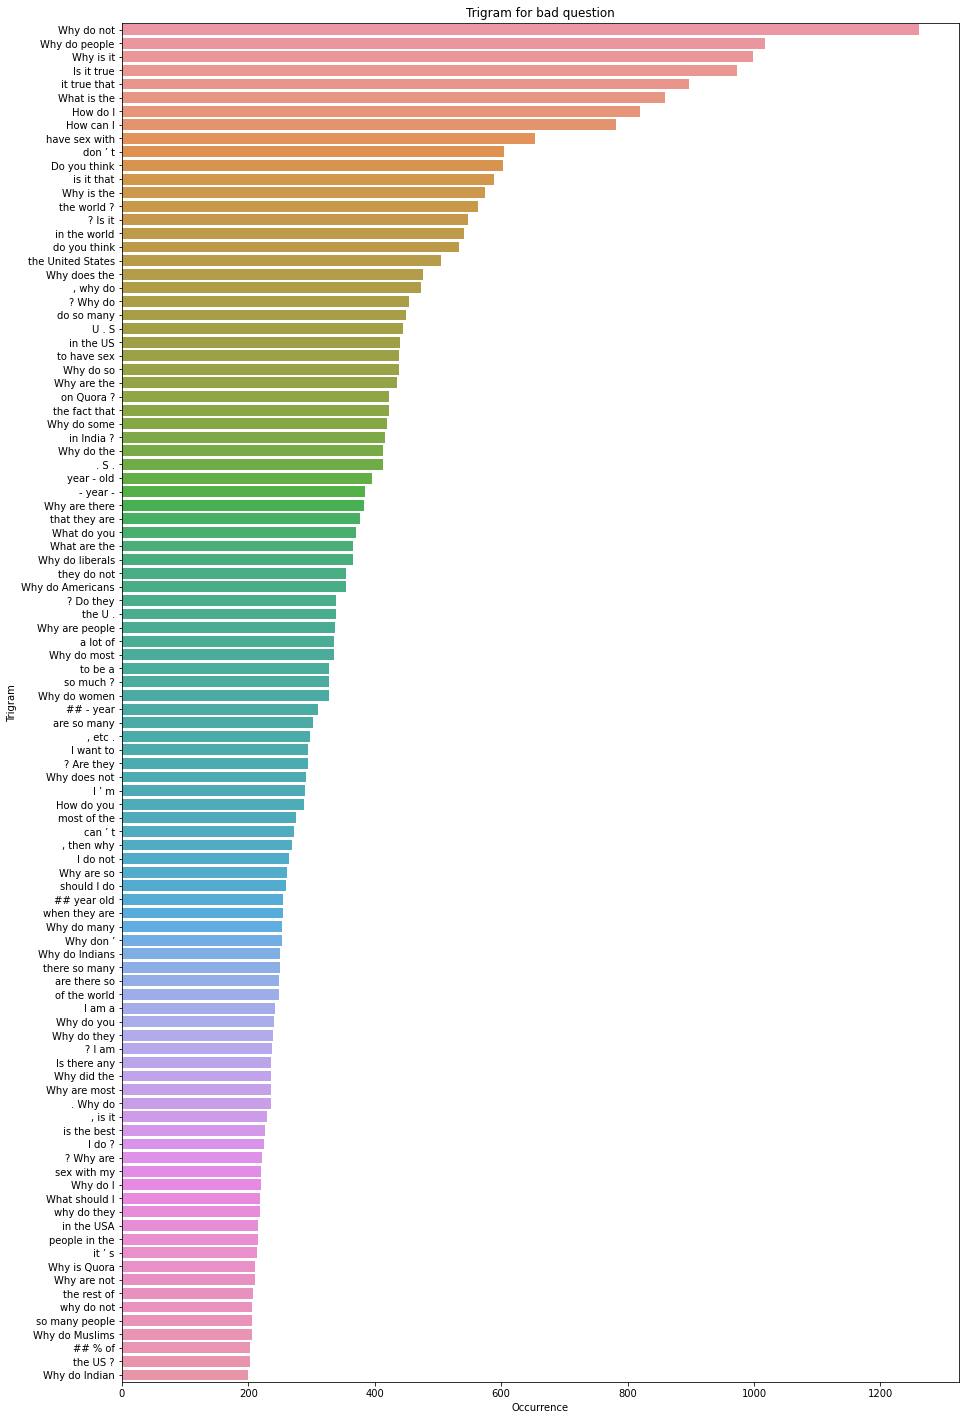

In [53]:
plt.figure(figsize=(15,25))
sns.barplot(data=sort_trigram_negative_df.iloc[:100],x="Occurrence",y="Trigram")
plt.title("Trigram for bad question")
plt.show()

Bigram and Trigram before cleaning

In [69]:
train2 = pd.read_csv("train/train.csv")

In [70]:
Normal_question_sentence2 = train2[train2.target.values == 0].question_text.values
Negative_question_sentence2 = train2[train2.target.values == 1].question_text.values

In [71]:
Bigram_normal_dict2 = {}
Bigram_negative_dict2 = {}

for i in Normal_question_sentence2:
  list_word_in_sentence = i.split()
  for i in range(len(list_word_in_sentence)-1):
    Word_visualize = list_word_in_sentence[i] +" " +list_word_in_sentence[i+1]
    try:
      Bigram_normal_dict2[Word_visualize] +=1
    except:
      Bigram_normal_dict2[Word_visualize] = 1

for i in Negative_question_sentence2:
  list_word_in_sentence = i.split()
  for i in range(len(list_word_in_sentence)-1):
    Word_visualize = list_word_in_sentence[i] +" " +list_word_in_sentence[i+1]
    try:
      Bigram_negative_dict2[Word_visualize] +=1
    except:
      Bigram_negative_dict2[Word_visualize] = 1


In [72]:
sort_bigram_normal2 = sorted([[i,j] for i,j in Bigram_normal_dict2.items()],key=lambda x:x[1],reverse = True)
sort_bigram_negative2 = sorted([[i,j] for i,j in Bigram_negative_dict2.items()],key=lambda x:x[1],reverse = True)

sort_bigram_normal_df2 = pd.DataFrame(sort_bigram_normal2)
sort_bigram_normal_df2.rename(columns={0:"Bigram",1:"Occurrence"},inplace=True)
sort_bigram_negative_df2 = pd.DataFrame(sort_bigram_negative2)
sort_bigram_negative_df2.rename(columns={0:"Bigram",1:"Occurrence"},inplace=True)

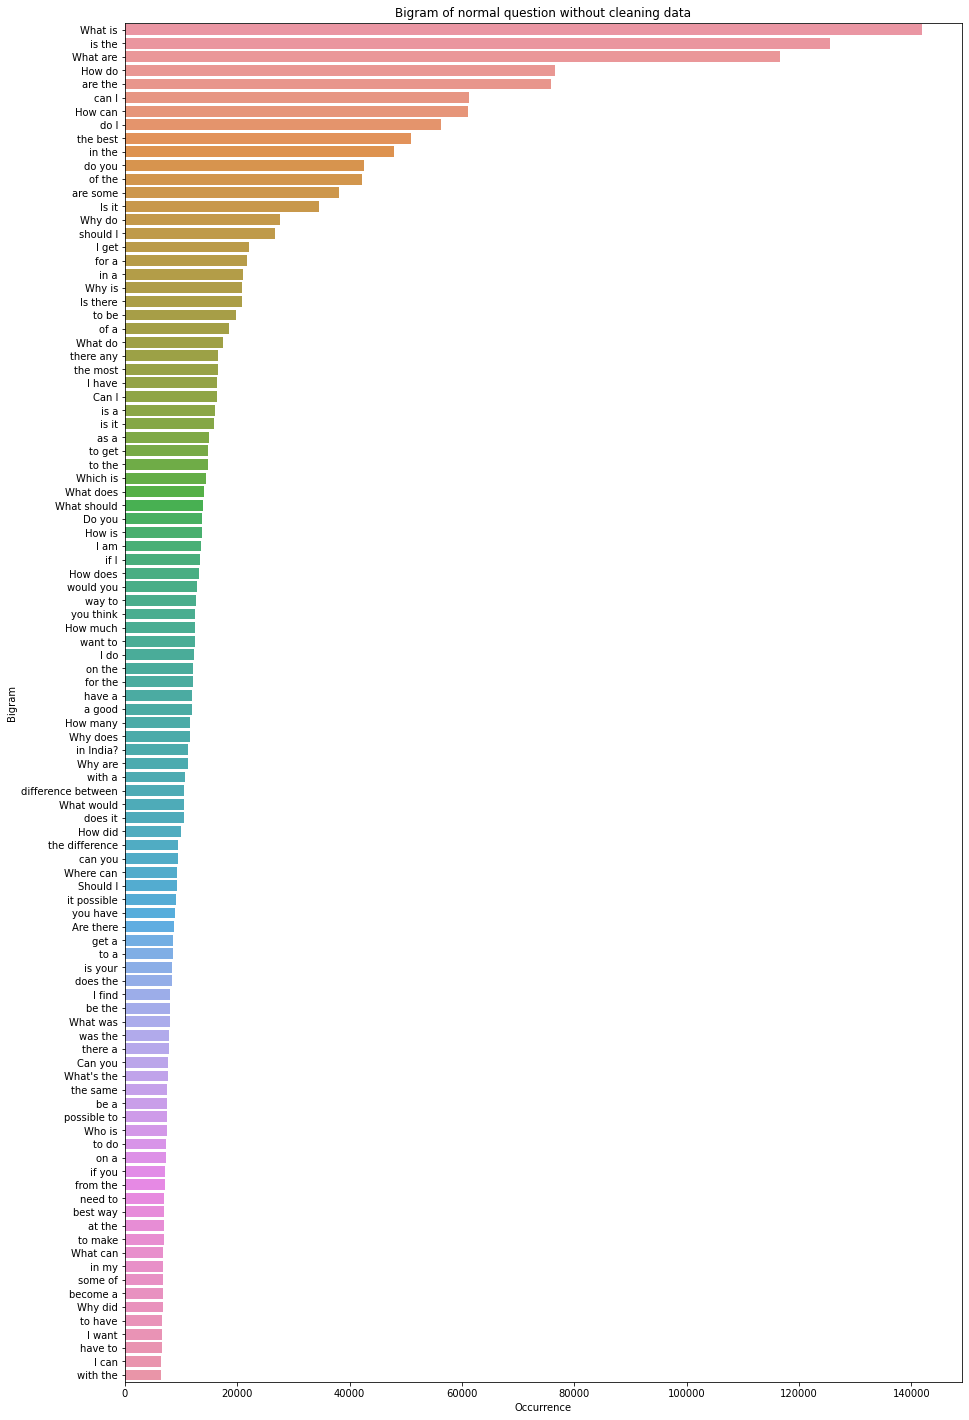

In [73]:
plt.figure(figsize=(15,25))
sns.barplot(data=sort_bigram_normal_df2.iloc[:100,:],y="Bigram",x="Occurrence")
plt.title("Bigram of normal question without cleaning data")
plt.show()

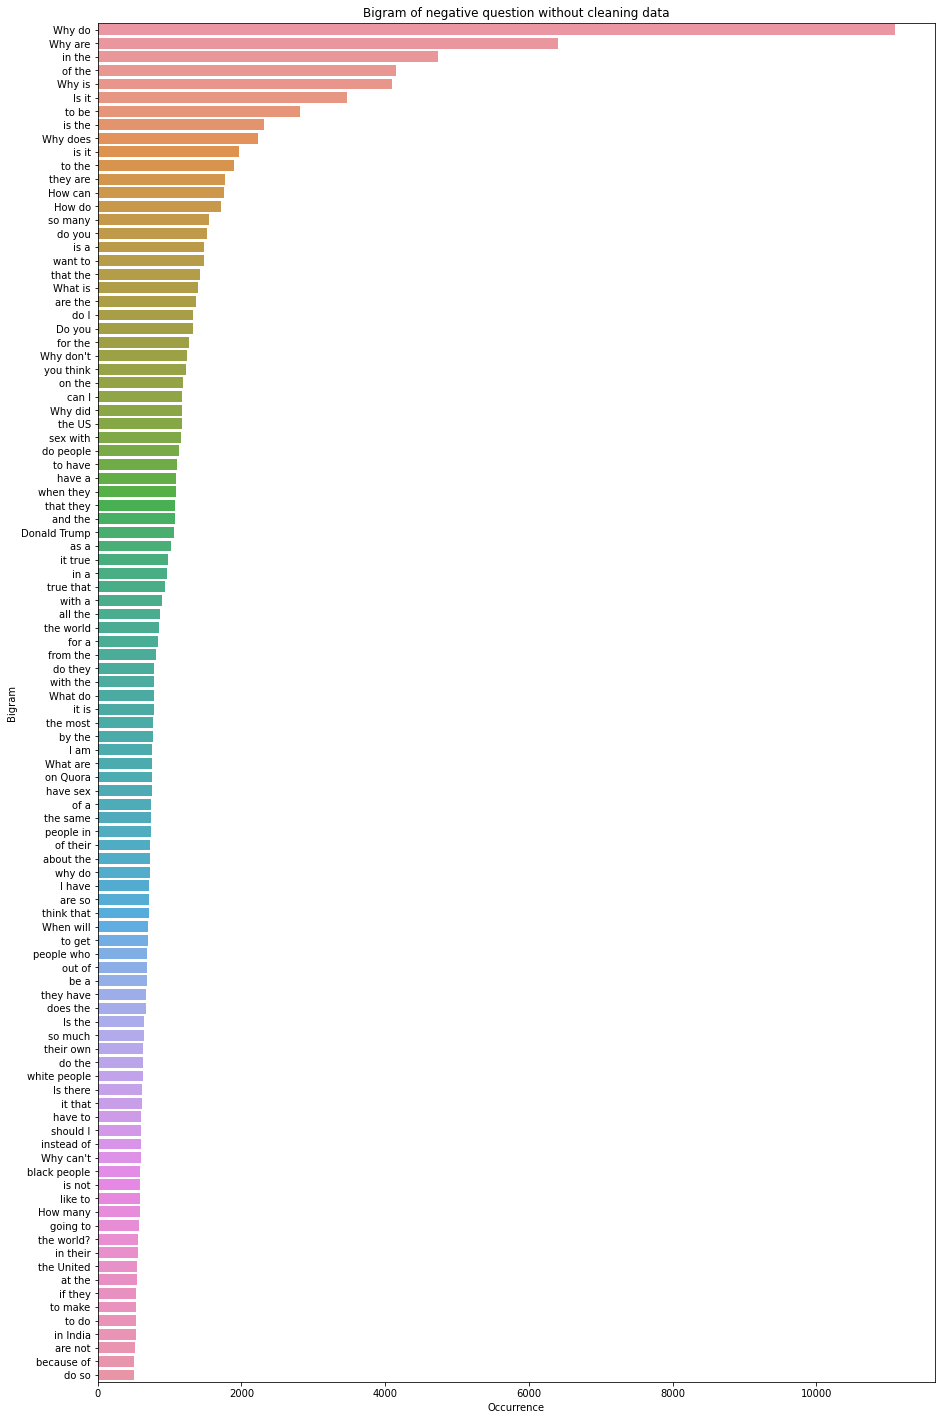

In [74]:
plt.figure(figsize=(15,25))
sns.barplot(data=sort_bigram_negative_df2.iloc[:100,:],y="Bigram",x="Occurrence")
plt.title("Bigram of negative question without cleaning data")
plt.show()

In [89]:
Trigram_normal_dict2 = {}
Trigram_negative_dict2 = {}

for i in Normal_question_sentence2:
  list_word_in_sentence = i.split()
  for i in range(len(list_word_in_sentence)-2):
    Word_visualize = list_word_in_sentence[i] +" " +list_word_in_sentence[i+1] +" " +list_word_in_sentence[i+2]
    try:
      Trigram_normal_dict2[Word_visualize] +=1
    except:
      Trigram_normal_dict2[Word_visualize] = 1

for i in Negative_question_sentence2:
  list_word_in_sentence = i.split()
  for i in range(len(list_word_in_sentence)-2):
    Word_visualize = list_word_in_sentence[i] +" " +list_word_in_sentence[i+1] +" "+list_word_in_sentence[i+2]
    try:
      Trigram_negative_dict2[Word_visualize] +=1
    except:
      Trigram_negative_dict2[Word_visualize] = 1

In [90]:
sort_trigram_normal2 = sorted([[i,j] for i,j in Trigram_normal_dict2.items()],key=lambda x:x[1],reverse = True)
sort_trigram_negative2 = sorted([[i,j] for i,j in Trigram_negative_dict2.items()],key=lambda x:x[1],reverse = True)

sort_trigram_normal_df2 = pd.DataFrame(sort_trigram_normal2)
sort_trigram_normal_df2.rename(columns={0:"Trigram",1:"Occurrence"},inplace=True)
sort_trigram_negative_df2 = pd.DataFrame(sort_trigram_negative2)
sort_trigram_negative_df2.rename(columns={0:"Trigram",1:"Occurrence"},inplace=True)

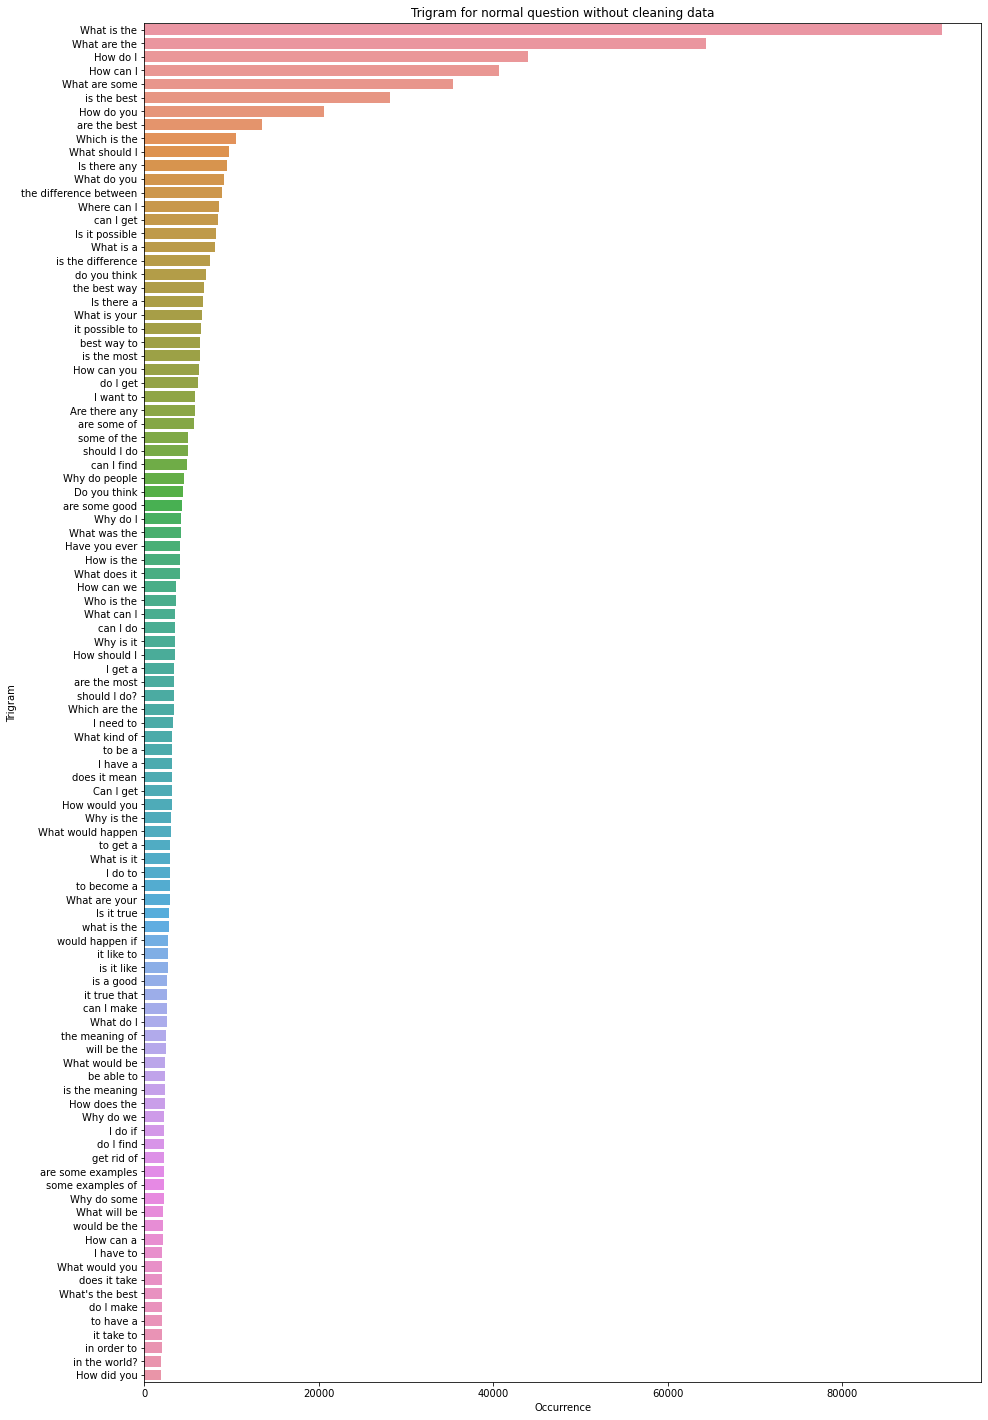

In [91]:
plt.figure(figsize=(15,25))
sns.barplot(data=sort_trigram_normal_df2.iloc[:100],x="Occurrence",y="Trigram")
plt.title("Trigram for normal question without cleaning data")
plt.show()

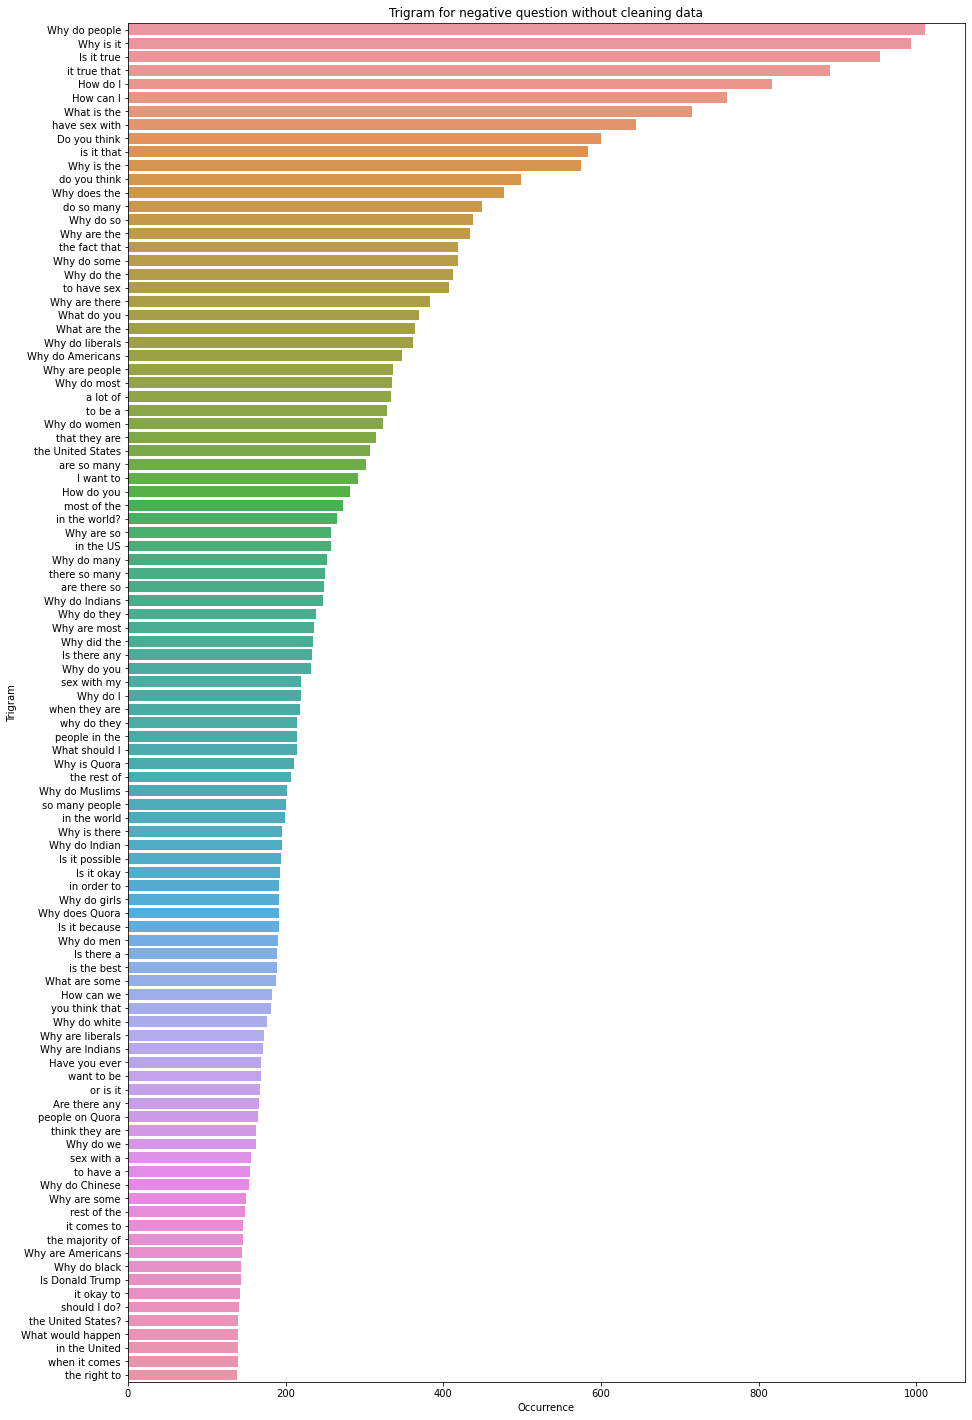

In [92]:
plt.figure(figsize=(15,25))
sns.barplot(data=sort_trigram_negative_df2.iloc[:100],x="Occurrence",y="Trigram")
plt.title("Trigram for negative question without cleaning data")
plt.show()

In [11]:
Start_X = clean_train.question_text.values
Start_Y = clean_train.target.values

In [12]:
list_sentence = Start_X

In [13]:
vocab_dictionary = {}
for sentence in list_sentence:
  for word in sentence:
    try:
      vocab_dictionary[word]+=1
    except:
      vocab_dictionary[word]=1

In [14]:
X = []
for i in Start_X:
  X.append(str(i))
X[:10]

['How did Quebec nationalists see their province as a nation in the ####s ? ',
 'Do you have an adopted dog ,  how would you encourage people to adopt and not shop ? ',
 'Why does velocity affect time ?  Does velocity affect space geometry ? ',
 'How did Otto von Guericke used the Magdeburg hemispheres ? ',
 'Can I convert montra helicon D to a mountain bike by just changing the tyres ? ',
 'Is Gaza slowly becoming Auschwitz ,  Dachau or Treblinka for Palestinians ? ',
 'Why does Quora automatically ban conservative opinions when reported ,  but does not do the same for liberal views ? ',
 'Is it crazy if I wash or wipe my groceries off ?  Germs are everywhere . ',
 'Is there such a thing as dressing moderately ,  and if so ,  how is that different than dressing modestly ? ',
 'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved ,  completely disregarding their feelings / lives so you get to have something go your way and feel temp

In [15]:
Start_X

array(['How did Quebec nationalists see their province as a nation in the ####s ? ',
       'Do you have an adopted dog ,  how would you encourage people to adopt and not shop ? ',
       'Why does velocity affect time ?  Does velocity affect space geometry ? ',
       ..., 'Is foam insulation toxic ? ',
       'How can one start a research project based on biochemistry at UG level ? ',
       'Who wins in a battle between a Wolverine and a Puma ? '],
      dtype=object)

In [16]:
Start_X

array(['How did Quebec nationalists see their province as a nation in the ####s ? ',
       'Do you have an adopted dog ,  how would you encourage people to adopt and not shop ? ',
       'Why does velocity affect time ?  Does velocity affect space geometry ? ',
       ..., 'Is foam insulation toxic ? ',
       'How can one start a research project based on biochemistry at UG level ? ',
       'Who wins in a battle between a Wolverine and a Puma ? '],
      dtype=object)

Check the number of vocab which is case sensitive.

In [17]:
print("Check the number of vocab with lower occurrence \n")
occurrence = 31
dict1 = sort_dictionary(X,lower=False)
for i in range(1,occurrence+1):
  dict_check = {}
  count = 1
  for word in dict1:
    if dict1[word] > i-1:
      dict_check[word] = count
      count += 1
  print("Check word of dictionary that occur more than " + str(i-1)+" times." +"\n")
  print("The number of word is " + str(len(dict_check))+"\n")

Check the number of vocab with lower occurrence 

Check word of dictionary that occur more than 0 times.

The number of word is 246534

Check word of dictionary that occur more than 1 times.

The number of word is 110987

Check word of dictionary that occur more than 2 times.

The number of word is 80043

Check word of dictionary that occur more than 3 times.

The number of word is 65728

Check word of dictionary that occur more than 4 times.

The number of word is 56977

Check word of dictionary that occur more than 5 times.

The number of word is 51003

Check word of dictionary that occur more than 6 times.

The number of word is 46415

Check word of dictionary that occur more than 7 times.

The number of word is 42943

Check word of dictionary that occur more than 8 times.

The number of word is 40178

Check word of dictionary that occur more than 9 times.

The number of word is 37824

Check word of dictionary that occur more than 10 times.

The number of word is 35827

Check word o

First We use based Model to predict outcome. So we want case unsensitive word

In [18]:
list_sentence = []
for i in Start_X:
  list_word = []
  for j in i.split():
    list_word.append(j.lower())
  list_sentence.append(list_word)

Check the number of vocab which is case un-sensitive.

In [19]:
print("Check the number of vocab with lower occurrence \n")
occurrence = 31
dict2 = sort_dictionary(X,lower=True)
for i in range(1,occurrence+1):
  dict_check = {}
  count = 1
  for word in dict2:
    if dict2[word] > i-1:
      dict_check[word] = count
      count += 1
  print("Check word of dictionary that occur more than " + str(i-1)+" times." +"\n")
  print("The number of word is " + str(len(dict_check))+"\n")

Check the number of vocab with lower occurrence 

Check word of dictionary that occur more than 0 times.

The number of word is 202942

Check word of dictionary that occur more than 1 times.

The number of word is 94456

Check word of dictionary that occur more than 2 times.

The number of word is 69278

Check word of dictionary that occur more than 3 times.

The number of word is 57695

Check word of dictionary that occur more than 4 times.

The number of word is 50488

Check word of dictionary that occur more than 5 times.

The number of word is 45538

Check word of dictionary that occur more than 6 times.

The number of word is 41700

Check word of dictionary that occur more than 7 times.

The number of word is 38739

Check word of dictionary that occur more than 8 times.

The number of word is 36288

Check word of dictionary that occur more than 9 times.

The number of word is 34247

Check word of dictionary that occur more than 10 times.

The number of word is 32519

Check word of

In [20]:
dict1 = sort_dictionary(X,lower=False)
dict2 = sort_dictionary(X,lower=True)

We basically set number of word in dictionary is 100000 and max words per sentence is 70. We automatically set OOV as index 0.

In [21]:
number_of_word = 100000
dict_use = {"OOV":0}
count = 1
for i in dict1:
  count +=1
  dict_use[i] =len(dict_use)
  if count ==100000:
    break

In [22]:
max_word_per_sentence = 70
padding = []
for sentence in X:
  list2 =[]
  for word in sentence.split():
    try:
      list2.append(dict_use[word])
    except:
      list2.append(dict_use["OOV"])
  padding.append(list2)

In [23]:
max_word_per_sentence = 70
padding_maxword = []
for i in padding:
  sentence  = i.copy()
  if len(i) > max_word_per_sentence:
    padding_maxword.append(sentence[:max_word_per_sentence])
  else:
    for i in range(max_word_per_sentence-len(i)):
      sentence.append(0)
    padding_maxword.append(sentence)

In [24]:
for i in padding_maxword[:10]:
  print(i)

[10, 66, 6949, 8033, 183, 68, 6664, 42, 5, 1266, 6, 2, 1564, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[58, 16, 26, 36, 3871, 522, 12, 79, 46, 16, 3640, 44, 4, 3067, 11, 29, 1899, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[17, 32, 2023, 390, 89, 1, 90, 2023, 390, 515, 5593, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10, 66, 14194, 10404, 56978, 139, 2, 42944, 30063, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[48, 9, 1119, 65729, 0, 1227, 4, 5, 4045, 1588, 56, 120, 1485, 2, 1

In [25]:
for i in range(len(padding_maxword[:40])):
  print(padding_maxword[i])
  print(X[i])
  print()

[10, 66, 6949, 8033, 183, 68, 6664, 42, 5, 1266, 6, 2, 1564, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
How did Quebec nationalists see their province as a nation in the ####s ? 

[58, 16, 26, 36, 3871, 522, 12, 79, 46, 16, 3640, 44, 4, 3067, 11, 29, 1899, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Do you have an adopted dog ,  how would you encourage people to adopt and not shop ? 

[17, 32, 2023, 390, 89, 1, 90, 2023, 390, 515, 5593, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Why does velocity affect time ?  Does velocity affect space geometry ? 

[10, 66, 14194, 10404, 56978, 139, 2, 42944, 30063, 1, 0, 0, 0, 0,

Train-test-split

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_validation,Y_train,Y_validation = train_test_split(np.array(padding_maxword),clean_train.target.values,test_size=0.15,shuffle=True)

In [27]:
from tensorflow.keras import layers
import keras
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# This is called to clear the original model session in order to use TensorBoard
from tensorflow.keras import backend as K
K.clear_session()

# Path to save model parameters

int_sequences_input = keras.Input(shape=(70,), dtype=float)
embedded_sequences = layers.Embedding(100000,300,trainable=True)(int_sequences_input)
x = layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128,return_sequences=True))(embedded_sequences)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
preds = layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(int_sequences_input, preds)
model2.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['acc'])
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 70, 300)           30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 256)           440320    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

In [28]:
model2.fit(X_train,Y_train, validation_data=(X_validation,Y_validation),
          epochs=3, batch_size=512,verbose=1)

Epoch 1/3
2169/2169 [==============================] - 705s 321ms/step - loss: 0.1458 - acc: 0.9462 - val_loss: 0.1085 - val_acc: 0.9553
Epoch 2/3
2169/2169 [==============================] - 686s 316ms/step - loss: 0.0952 - acc: 0.9615 - val_loss: 0.1072 - val_acc: 0.9568
Epoch 3/3
2169/2169 [==============================] - 682s 314ms/step - loss: 0.0774 - acc: 0.9694 - val_loss: 0.1159 - val_acc: 0.9564


In [29]:
y_predict1 = model2.predict(X_validation)
y_predict = pd.DataFrame(y_predict1,columns=["Y_prediction"])
y_predict

,Y_prediction
0,0.142256
1,0.014878
2,0.022014
3,0.000857
4,0.000091
...,...
195914,0.000034
195915,0.000010
195916,0.000011
195917,0.000641


In [30]:
y_predict["Y_prediction"] = np.where(y_predict.Y_prediction.values>=0.5,1,0)

In [31]:
from sklearn.metrics import f1_score
f1score = f1_score(Y_validation,y_predict.Y_prediction.values)
print("F1_score of the model is ",f1score)

F1_score of the model is  0.5936741973840666


Load glove word embedding

Create new word index for Glove embedding

In [ ]:
crate_dict_for_glove = sort_dictionary(X,lower=False)
max_word_per_sentence = 70
number_of_word = 100000
dict_glove = {"OOV":0}
count = 1
for i in crate_dict_for_glove:
  count +=1
  dict_glove[i] =len(dict_glove)
  if count ==100000:
    break

In [ ]:
glove_padding = []
for sentence in X:
  list2 =[]
  for word in sentence.split():
    try:
      list2.append(dict_glove[word])
    except:
      list2.append(dict_glove["OOV"])
  glove_padding.append(list2)

In [ ]:
for j in glove_padding[:20]:
  print(j)

[10, 66, 6949, 8033, 183, 68, 6664, 42, 5, 1266, 6, 2, 1564, 1]
[58, 16, 26, 36, 3871, 522, 12, 79, 46, 16, 3640, 44, 4, 3067, 11, 29, 1899, 1]
[17, 32, 2023, 390, 89, 1, 90, 2023, 390, 515, 5593, 1]
[10, 66, 14194, 10404, 56978, 139, 2, 42944, 30063, 1]
[48, 9, 1119, 65729, 0, 1227, 4, 5, 4045, 1588, 56, 120, 1485, 2, 10057, 1]
[21, 9305, 3899, 778, 20494, 12, 56979, 27, 0, 15, 2626, 1]
[17, 32, 125, 2568, 1697, 1633, 2445, 51, 4337, 12, 81, 32, 29, 13, 2, 159, 15, 1278, 917, 1]
[21, 18, 1997, 37, 9, 3002, 27, 5887, 23, 13288, 247, 1, 80044, 14, 3730, 19]
[21, 47, 231, 5, 212, 42, 6745, 20495, 12, 11, 37, 65, 12, 79, 7, 22, 151, 88, 6745, 26962, 1]
[21, 18, 120, 67, 27, 26, 16, 112, 135, 6, 80, 2304, 16045, 16, 1392, 3166, 4, 2, 44, 16, 713, 1723, 12, 914, 24036, 68, 1083, 57, 1100, 65, 16, 38, 4, 26, 220, 129, 34, 99, 11, 121, 7082, 53, 6720, 19, 10, 66, 164, 190, 1]
[3, 20, 16, 177, 54, 2779, 1]
[10, 115, 2, 14037, 31271, 3175, 1]
[3, 7, 2, 7111, 12, 692, 2627, 229, 2643, 15, 143, 1

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
padding_maxword_for_glove = []
for i in glove_padding:
  sentence  = i.copy()
  if len(i) > max_word_per_sentence:
    padding_maxword_for_glove.append(sentence[:max_word_per_sentence])
  else:
    for i in range(max_word_per_sentence-len(i)):
      sentence.append(0)
    padding_maxword_for_glove.append(sentence)
X_train,X_validation,Y_train,Y_validation = train_test_split(np.array(padding_maxword_for_glove),clean_train.target.values,test_size=0.15,shuffle=True)

In [ ]:
for i in padding_maxword_for_glove[:2]:
  print(i)

[10, 66, 6949, 8033, 183, 68, 6664, 42, 5, 1266, 6, 2, 1564, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[58, 16, 26, 36, 3871, 522, 12, 79, 46, 16, 3640, 44, 4, 3067, 11, 29, 1899, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
def load_glove_fast(word_index, max_words, embed_size=300):
    EMBEDDING_FILE = 'embedding/glove.840B.300d/glove.840B.300d.txt'
    emb_mean, emb_std = -0.005838499, 0.48782197

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_words, embed_size))
    with open(EMBEDDING_FILE, 'r', encoding="utf8") as f:
        for line in f:
            word, vec = line.split(' ', 1)
            if word not in word_index:
                continue
            i = word_index[word]
            if i >= max_words:
                continue
            embedding_vector = np.asarray(vec.split(' '), dtype='float32')[:300]
            if len(embedding_vector) == 300:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
Embedding_matrix = load_glove_fast(dict_glove,100000)
Embedding_matrix

array([[-0.51004189,  0.48892707, -0.39317015, ..., -0.33855094,
        -0.08941182, -1.10924053],
       [-0.086864  ,  0.19160999,  0.10915   , ..., -0.01516   ,
         0.11108   ,  0.20649999],
       [ 0.27204001, -0.06203   , -0.1884    , ...,  0.13015001,
        -0.18317001,  0.1323    ],
       ...,
       [-0.26304642, -0.34613858, -1.18406253, ...,  1.57106991,
        -0.42640117, -0.28469739],
       [-0.057969  , -0.14964999,  0.082356  , ..., -0.09207   ,
         0.10385   ,  0.16963001],
       [-0.067399  , -0.1991    , -0.11715   , ...,  0.36135   ,
        -0.12372   ,  0.044732  ]])

In [ ]:
from tensorflow.keras import layers
import keras
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# This is called to clear the original model session in order to use TensorBoard
from tensorflow.keras import backend as K
K.clear_session()

# Path to save model parameters


int_sequences_input = keras.Input(shape=(70,), dtype=float)
embedded_sequences = layers.Embedding(100000,300,weights=[Embedding_matrix],trainable=True,)(int_sequences_input)
x = layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64,return_sequences=True))(embedded_sequences)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.1)(x)
preds = layers.Dense(1, activation="sigmoid")(x)
new_model = keras.Model(int_sequences_input, preds)
new_model.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['acc'])
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 70, 300)           30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 128)           187392    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17    

In [ ]:
new_model.fit(X_train,Y_train, validation_data=(X_validation,Y_validation),
          epochs=2, batch_size=512,verbose=1)

Epoch 1/2
2169/2169 [==============================] - 658s 301ms/step - loss: 0.1337 - acc: 0.9486 - val_loss: 0.1007 - val_acc: 0.9593
Epoch 2/2
2169/2169 [==============================] - 659s 304ms/step - loss: 0.0921 - acc: 0.9633 - val_loss: 0.1002 - val_acc: 0.9601


In [ ]:
y_predict_glove = new_model.predict(X_validation)
y_predict1 = pd.DataFrame(y_predict_glove,columns=["Y_prediction_Proba"])
y_predict1["Y_prediction_final"] = np.where(y_predict1.Y_prediction_Proba.values>=0.5,1,0)


In [ ]:
y_predict1.to_csv("Glove_Prediction.csv",index=False)

In [ ]:
f1score = f1_score(Y_validation,y_predict1.Y_prediction_final.values)
print("F1_score of the model is ",f1score)

F1_score of the model is  0.6685038368592869


In [ ]:
print("Find the best F1-score model")
for i in range(20,70,1):
  y_predict = pd.DataFrame(y_predict_glove,columns=["Y_prediction"])
  y_predict["Y_prediction"] = np.where(y_predict.Y_prediction.values>=(i/100),1,0)
  f1score = f1_score(Y_validation,y_predict.Y_prediction.values)

  print("F1 score of boundary = "+str(i)+"% is "+str(f1score))
  print()


Find the best F1-score model
F1 score of boundary = 20% is 0.6626349026028268

F1 score of boundary = 21% is 0.6644385929376815

F1 score of boundary = 22% is 0.6669851887243192

F1 score of boundary = 23% is 0.6686879823594267

F1 score of boundary = 24% is 0.6692409378696167

F1 score of boundary = 25% is 0.6712093006919322

F1 score of boundary = 26% is 0.6732974656661476

F1 score of boundary = 27% is 0.6745182012847966

F1 score of boundary = 28% is 0.6755171793488037

F1 score of boundary = 29% is 0.6757295631683887

F1 score of boundary = 30% is 0.6767296516940171

F1 score of boundary = 31% is 0.6777875975843276

F1 score of boundary = 32% is 0.6790953318230771

F1 score of boundary = 33% is 0.6795317700736752

F1 score of boundary = 34% is 0.679504088630968

F1 score of boundary = 35% is 0.6795173408211278

F1 score of boundary = 36% is 0.6796012679983195

F1 score of boundary = 37% is 0.680184686417853

F1 score of boundary = 38% is 0.6803116641469938

F1 score of boundary = 

In [ ]:
print("F1 score of boundary = 34% is 0.6755271465876758")

F1 score of boundary = 34% is 0.6755271465876758


In [ ]:
def load_fasttext_fast(word_index, max_words=100000, embed_size=300):
    EMBEDDING_FILE = 'embedding/wiki-news-300d-1M/wiki-news-300d-1M.vec'
    emb_mean, emb_std = -0.0033470048, 0.109855264

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_words, embed_size))
    with open(EMBEDDING_FILE, 'r', encoding="utf8") as f:       
        for line in f:
            if len(line) <= 100:
                continue
            word, vec = line.split(' ', 1)
            if word not in word_index:
                continue
            i = word_index[word]
            if i >= max_words:
                continue
            embedding_vector = np.asarray(vec.split(' '), dtype='float32')[:300]
            if len(embedding_vector) == 300:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
#use the same dictionary for fasttext
embedding_matrix = load_fasttext_fast(dict_glove,100000)

K.clear_session()


int_sequences_input = keras.Input(shape=(70,), dtype=float)
embedded_sequences = layers.Embedding(100000,300,weights=[Embedding_matrix],trainable=True,)(int_sequences_input)
x = layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64,return_sequences=True))(embedded_sequences)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.1)(x)
preds = layers.Dense(1, activation="sigmoid")(x)
new_model2 = keras.Model(int_sequences_input, preds)
new_model2.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['acc'])
new_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 70, 300)           30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 128)           187392    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17    

In [ ]:
new_model2.fit(X_train,Y_train, validation_data=(X_validation,Y_validation),
          epochs=2, batch_size=512,verbose=2)

Epoch 1/2
2169/2169 - 692s - loss: 0.1159 - acc: 0.9541 - val_loss: 0.1014 - val_acc: 0.9588
Epoch 2/2
2169/2169 - 694s - loss: 0.0927 - acc: 0.9629 - val_loss: 0.0994 - val_acc: 0.9603


In [ ]:
y_predict_fasttext = new_model2.predict(X_validation)
y_predict = pd.DataFrame(y_predict_fasttext,columns=["Y_prediction"])
y_predict["Y_prediction_final"] = np.where(y_predict.Y_prediction.values>=0.5,1,0)


In [ ]:
y_predict_fasttext

array([[4.0429831e-02],
       [3.9071412e-04],
       [4.7073155e-04],
       ...,
       [1.6899848e-03],
       [6.4358443e-05],
       [1.7116500e-04]], dtype=float32)

In [ ]:
f1score = f1_score(Y_validation,y_predict.Y_prediction_final.values)
print("F1_score of the model is ",f1score)

F1_score of the model is  0.6532470430707432


In [ ]:
print("Find the best F1-score model")
for i in range(20,70,1):
  y_predict = pd.DataFrame(y_predict_fasttext,columns=["Y_prediction"])
  y_predict["Y_prediction"] = np.where(y_predict.Y_prediction.values>=(i/100),1,0)
  f1score = f1_score(Y_validation,y_predict.Y_prediction.values)

  print("F1 score of boundary = "+str(i)+"% is "+str(f1score))
  print()

Find the best F1-score model
F1 score of boundary = 20% is 0.6549534432270588

F1 score of boundary = 21% is 0.6581595255547411

F1 score of boundary = 22% is 0.661064425770308

F1 score of boundary = 23% is 0.6635922661747626

F1 score of boundary = 24% is 0.6654688687720267

F1 score of boundary = 25% is 0.6681807064742672

F1 score of boundary = 26% is 0.6694708564561167

F1 score of boundary = 27% is 0.6706920575940548

F1 score of boundary = 28% is 0.6723720795868992

F1 score of boundary = 29% is 0.6737878235508568

F1 score of boundary = 30% is 0.6747689021470925

F1 score of boundary = 31% is 0.6752483351315153

F1 score of boundary = 32% is 0.6752290821691452

F1 score of boundary = 33% is 0.6765319673686208

F1 score of boundary = 34% is 0.6765167464114833

F1 score of boundary = 35% is 0.6769040343480447

F1 score of boundary = 36% is 0.6781990706392284

F1 score of boundary = 37% is 0.6772069550132083

F1 score of boundary = 38% is 0.6760911118190507

F1 score of boundary =

In [ ]:
print("Best F1 score of Fasttext at boundary = 37% is ",0.6770760506486445)

Best F1 score of Fasttext at boundary = 37% is  0.6770760506486445


Paragram_dict

In [ ]:
def load_para_fast(word_index, max_words=100000, embed_size=300):
    EMBEDDING_FILE = 'embedding/paragram_300_sl999/paragram_300_sl999.txt'
    emb_mean, emb_std = -0.0053247833, 0.49346462

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_words, embed_size))
    with open(EMBEDDING_FILE, 'r', encoding="utf8", errors="ignore") as f:        
        for line in f:
            if len(line) <= 100:
                continue
            word, vec = line.split(' ', 1)
            if word not in word_index:
                continue
            i = word_index[word]
            if i >= max_words:
                continue
            embedding_vector = np.asarray(vec.split(' '), dtype='float32')[:300]
            if len(embedding_vector) == 300:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
paragram_dict = sort_dictionary(X,lower=True)
paragram_dict

{'?': 1381192,
 'the': 665695,
 'what': 471275,
 'is': 471008,
 'a': 411421,
 'to': 407953,
 'in': 378109,
 'of': 333513,
 'i': 331007,
 'how': 290455,
 'do': 269402,
 'and': 257901,
 'are': 249024,
 ',': 235096,
 'for': 204464,
 'you': 202227,
 'can': 178103,
 'why': 163946,
 'it': 147606,
 '.': 134056,
 'my': 112645,
 'that': 107758,
 'have': 99800,
 'if': 98952,
 'with': 95920,
 'on': 94851,
 'or': 94597,
 'does': 92652,
 'be': 92089,
 'not': 86718,
 '"': 73272,
 '#': 70598,
 'from': 69848,
 'your': 67682,
 'an': 67354,
 '-': 67094,
 'which': 65876,
 'should': 65675,
 'would': 63185,
 'when': 62903,
 'get': 62739,
 'best': 62476,
 'as': 60533,
 '(': 56618,
 ')': 56594,
 'people': 55725,
 '##': 55397,
 'some': 54458,
 'there': 54408,
 'will': 53308,
 'who': 52259,
 'like': 49484,
 'at': 47937,
 'about': 45165,
 'did': 45103,
 'they': 44459,
 'by': 42706,
 'was': 42365,
 '/': 42137,
 'we': 40790,
 'any': 40157,
 'so': 39065,
 'good': 38439,
 'me': 36606,
 'their': 34969,
 'am': 33886,

In [ ]:
embedding_layer = load_para_fast(paragram_dict,100000)


int_sequences_input = keras.Input(shape=(70,), dtype=float)
embedded_sequences = layers.Embedding(100000,300,weights=[Embedding_matrix],trainable=True,)(int_sequences_input)
x = layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64,return_sequences=True))(embedded_sequences)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.1)(x)
preds = layers.Dense(1, activation="sigmoid")(x)
new_model3 = keras.Model(int_sequences_input, preds)
new_model3.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['acc'])
new_model3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 70, 300)           30000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 128)           187392    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17  

In [ ]:
new_model3.fit(X_train,Y_train, validation_data=(X_validation,Y_validation),
          epochs=2, batch_size=512,verbose=2)

Epoch 1/2
2169/2169 - 665s - loss: 0.1150 - acc: 0.9555 - val_loss: 0.1026 - val_acc: 0.9594
Epoch 2/2
2169/2169 - 658s - loss: 0.0925 - acc: 0.9631 - val_loss: 0.1002 - val_acc: 0.9601


In [ ]:
y_predict_paragram = new_model3.predict(X_validation)
y_predict = pd.DataFrame(y_predict_paragram,columns=["Y_prediction"])
y_predict["Y_prediction_final"] = np.where(y_predict.Y_prediction.values>=0.5,1,0)

In [ ]:
y_predict

,Y_prediction,Y_prediction_final
0,0.062933,0
1,0.000192,0
2,0.000356,0
3,0.230677,0
4,0.000074,0
...,...,...
195914,0.001801,0
195915,0.005098,0
195916,0.000912,0
195917,0.000051,0


In [ ]:
f1score = f1_score(Y_validation,y_predict.Y_prediction_final.values)
print("F1_score of the model is ",f1score)

F1_score of the model is  0.6591930207197382


In [ ]:
print("Find the best F1-score model")
for i in range(20,70,1):
  y_predict = pd.DataFrame(y_predict_paragram,columns=["Y_prediction"])
  y_predict["Y_prediction"] = np.where(y_predict.Y_prediction.values>=(i/100),1,0)
  f1score = f1_score(Y_validation,y_predict.Y_prediction.values)

  print("F1 score of boundary = "+str(i)+"% is"+str(f1score))
  print()

Find the best F1-score model
F1 score of boundary = 20% is0.664916646780077

F1 score of boundary = 21% is0.6671032676134013

F1 score of boundary = 22% is0.6677355268202573

F1 score of boundary = 23% is0.6697923643670463

F1 score of boundary = 24% is0.6714402764418795

F1 score of boundary = 25% is0.6729476068898559

F1 score of boundary = 26% is0.6746716970180657

F1 score of boundary = 27% is0.6760099531615925

F1 score of boundary = 28% is0.6772147230213175

F1 score of boundary = 29% is0.6780518659076533

F1 score of boundary = 30% is0.6790600052471797

F1 score of boundary = 31% is0.6796644751756972

F1 score of boundary = 32% is0.6797699310554983

F1 score of boundary = 33% is0.679745085995086

F1 score of boundary = 34% is0.679368029739777

F1 score of boundary = 35% is0.6789699570815451

F1 score of boundary = 36% is0.6792986870036953

F1 score of boundary = 37% is0.6781204227861131

F1 score of boundary = 38% is0.676268751994893

F1 score of boundary = 39% is0.6750583125552

In [ ]:
print("Best F1 score at boundary = 28% is",0.6730135210224115)

Best F1 score at boundary = 28% is 0.6730135210224115


Use three word_embedding_layer at the same_time & Basic Boosting algorithm


In [ ]:
coefficient = [0.33,0.33,0.34] #for glove fasttext and paragram

In [ ]:
basic_ensemble = 0.33*y_predict_glove+0.33*y_predict_fasttext+0.34*y_predict_paragram

In [ ]:
ensemble_df = pd.DataFrame(basic_ensemble,columns=["Y_prediction_Proba"])

In [ ]:
print("Find the best F1-score model")
for i in range(20,70,1):
  ensemble_df["Y_prediction"] = np.where(ensemble_df.Y_prediction_Proba.values >=(i/100),1,0)
  f1score = f1_score(Y_validation,ensemble_df.Y_prediction.values)
  print("F1 score of boundary = "+str(i)+"% is "+str(f1score))
  print()

Find the best F1-score model
F1 score of boundary = 20% is 0.6665555518517283

F1 score of boundary = 21% is 0.6689366866698131

F1 score of boundary = 22% is 0.6714865463970263

F1 score of boundary = 23% is 0.6731538992408558

F1 score of boundary = 24% is 0.675384454440841

F1 score of boundary = 25% is 0.6775115565122269

F1 score of boundary = 26% is 0.6785447029897017

F1 score of boundary = 27% is 0.6790416576732139

F1 score of boundary = 28% is 0.6809515162520429

F1 score of boundary = 29% is 0.6818548091714893

F1 score of boundary = 30% is 0.6822015090989793

F1 score of boundary = 31% is 0.6838863797543951

F1 score of boundary = 32% is 0.6850047036688617

F1 score of boundary = 33% is 0.6842624943035089

F1 score of boundary = 34% is 0.6849398974044866

F1 score of boundary = 35% is 0.6852731132985911

F1 score of boundary = 36% is 0.68545405005644

F1 score of boundary = 37% is 0.685420590081607

F1 score of boundary = 38% is 0.6857866213062225

F1 score of boundary = 39

In [ ]:
print("F1 score of boundary = 38% is 0.6857866213062225")

F1 score of boundary = 38% is 0.6857866213062225


In [ ]:
def find_best_score(dataframe):
  list1 = []
  for i in range(30,50,1):
    dataframe["Y_prediction"] = np.where(dataframe.Y_prediction_Proba.values >=(i/100),1,0)
    f1score = f1_score(Y_validation,dataframe.Y_prediction.values)
    list1.append([i,f1score])
  list_a = sorted(list1,key = lambda x:x[1],reverse=True)
  return list_a[0]

In [ ]:
find_best_score(ensemble_df)

[38, 0.6857866213062225]

In [ ]:
list_a = []
for i in np.arange(0.20,0.50,0.01):
  for j in np.arange(0.20,0.50,0.01):
    for k in np.arange(0.20,0.50,0.01):
      i = round(i,2)
      j = round(j,2)
      k = round(k,2)
      if i+j+k ==1:
        basic_ensemble2 = i*y_predict_glove + j*y_predict_fasttext + k*y_predict_paragram
        ensemble_df2 = pd.DataFrame(basic_ensemble2,columns=["Y_prediction_Proba"])
        best_f1score_for_coefficient = find_best_score(ensemble_df2)
        f1_best_score_coefficient = best_f1score_for_coefficient[1]
        best_boundary_for_coefficient = best_f1score_for_coefficient[0]
        coefficient = [i,j,k] #glove fasttext paragram
        list_a.append([coefficient,best_boundary_for_coefficient,f1_best_score_coefficient])



In [ ]:
sort_list_a = sorted(list_a,key=lambda x:x[2],reverse=True)

In [ ]:
best_parameter = sort_list_a[0][0]
best_parameter

[0.38, 0.21, 0.41]

In [ ]:
list_ab = sort_list_a[0]
list_ab

[[0.38, 0.21, 0.41], 35, 0.6864818960858489]

In [ ]:
len(list_a)

655

In [ ]:
parameter_tuning_Answer = best_parameter[0]*y_predict_glove + best_parameter[1]*y_predict_fasttext + best_parameter[2]*y_predict_paragram

In [ ]:
parameter_tuning_Answer

array([[6.8212405e-02],
       [2.9087716e-04],
       [3.8961406e-04],
       ...,
       [1.5532168e-03],
       [7.0507696e-05],
       [7.8445752e-05]], dtype=float32)

In [ ]:
ensemble_df_best_tuning = pd.DataFrame(parameter_tuning_Answer,columns=["Y_prediction_Proba"])
ensemble_df_best_tuning["Y_prediction"] = np.where(ensemble_df_best_tuning.Y_prediction_Proba>=0.34,1,0)

In [ ]:
ensemble_df_best_tuning

,Y_prediction_Proba,Y_prediction
0,0.068212,0
1,0.000291,0
2,0.000390,0
3,0.194979,0
4,0.000069,0
...,...,...
195914,0.001597,0
195915,0.005696,0
195916,0.001553,0
195917,0.000071,0


In [ ]:
print("Best Coefficient of Glove = ",list_ab[0][0])
print("Best Coefficient of Fasttext = ",list_ab[0][1])
print("Best Coefficient of Paragram = ",list_ab[0][2])
print("Boundary = ",list_ab[1])
print("Best F1 score = ",find_best_score(ensemble_df_best_tuning)[1])
print("Boundary found to check again",find_best_score(ensemble_df_best_tuning)[0])

Best Coefficient of Glove =  0.38
Best Coefficient of Fasttext =  0.21
Best Coefficient of Paragram =  0.41
Boundary =  35
Best F1 score =  0.6864818960858489
Boundary found to check again 35


In [ ]:
clean_test = test.copy()
clean_test["question_text"]= clean_test.question_text.apply(lambda x: clean_text(x))
clean_test["question_text"]= clean_test.question_text.apply(lambda x: clean_numbers(x))

In [ ]:
clean_test["question_text"] = clean_test["question_text"].apply(lambda x: check_missspell(x))

In [ ]:
Test_X = clean_test.question_text.values

In [ ]:
Test_X

array(['Why do so many women become so rude and arrogant when they get just a little bit of wealth and power ? ',
       'When should I apply for RV college of engineering and BMS college of engineering ?  Should I wait for the COMEDK result or am I supposed to apply before the result ? ',
       'What is it really like to be a nurse practitioner ? ', ...,
       'Where I can find best friendship quotes in Telugu ? ',
       'What are the causes of refraction of light ? ',
       'Climate change is a worrying topic .  How much time do we have left to find another planet ?  I mean ,  I do not think humans will survive on this earth for another #### years .  .  What do you think ? '],
      dtype=object)

In [ ]:
max_word_per_sentence = 70
test_padding = []
for sentence in Test_X:
  list2 =[]
  for word in sentence.split():
    try:
      list2.append(dict_use[word])
    except:
      list2.append(dict_use["OOV"])
  test_padding.append(list2)

In [ ]:
max_word_per_sentence = 70
test_padding_maxword = []
for i in test_padding:
  sentence  = i.copy()
  if len(i) > max_word_per_sentence:
    test_padding_maxword.append(sentence[:max_word_per_sentence])
  else:
    for i in range(max_word_per_sentence-len(i)):
      sentence.append(0)
    test_padding_maxword.append(sentence)

In [ ]:
for i in test_padding_maxword[:10]:
  print(i)

[17, 13, 65, 86, 145, 117, 65, 1811, 11, 4111, 51, 55, 38, 120, 5, 787, 1653, 8, 2226, 11, 329, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[128, 50, 9, 394, 15, 10606, 181, 8, 195, 11, 7581, 181, 8, 195, 1, 116, 9, 1568, 15, 2, 3980, 997, 27, 73, 9, 1611, 4, 394, 163, 2, 997, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 7, 18, 152, 49, 4, 28, 5, 4570, 14149, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[93, 14, 3988, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[21, 499, 152, 377, 63, 44, 2340, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
len(test_padding_maxword)

375806

In [ ]:
y_predict_glove = new_model.predict(np.array(test_padding_maxword))
y_predict_fasttext = new_model2.predict(np.array(test_padding_maxword))
y_predict_paragram = new_model3.predict(np.array(test_padding_maxword))


In [ ]:
#Case1 Average case
Coefficient_Glove = 0.33
Coefficient_Fasttext =0.33
Coefficient_Paragram = 0.34
y_predict_proba1 = Coefficient_Glove*y_predict_glove + Coefficient_Fasttext*y_predict_fasttext + Coefficient_Paragram*y_predict_paragram
submission_1 = pd.DataFrame(y_predict_proba1,columns=["Y_prediction_Proba"])


In [ ]:
submission_to_answer = pd.read_csv("submission/sample_submission.csv")
submission_to_answer

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [ ]:
decision_boundary = 38 #for the first submission case
submission_1["Y_test_Predict"] = np.where(submission_1.Y_prediction_Proba >= decision_boundary/100,1,0)

In [ ]:
submission_1

,Y_prediction_Proba,Y_test_Predict
0,0.809963,1
1,0.000193,0
2,0.000149,0
3,0.000194,0
4,0.005191,0
...,...,...
375801,0.000195,0
375802,0.000246,0
375803,0.000766,0
375804,0.000031,0


In [ ]:
#Case 2 Optimization case
Coefficient_Glove = list_ab[0][0]
Coefficient_Fasttext = list_ab[0][1]
Coefficient_Paragram = list_ab[0][2]

In [ ]:
y_predict_proba2 = Coefficient_Glove*y_predict_glove + Coefficient_Fasttext*y_predict_fasttext + Coefficient_Paragram*y_predict_paragram
submission_2 = pd.DataFrame(y_predict_proba2,columns=["Y_prediction_Proba"])
decision_boundary2 = list_ab[1]
submission_2["Y_test_Predict"] = np.where(submission_2.Y_prediction_Proba >= decision_boundary2/100,1,0)

In [ ]:
submission_2

,Y_prediction_Proba,Y_test_Predict
0,0.809210,1
1,0.000195,0
2,0.000143,0
3,0.000190,0
4,0.005068,0
...,...,...
375801,0.000159,0
375802,0.000213,0
375803,0.000746,0
375804,0.000028,0


Answer in two submission

In [ ]:
submission_to_answer_case1 = submission_to_answer.copy()
submission_to_answer_case1["prediction"] = submission_1["Y_test_Predict"]

In [ ]:
submission_to_answer_case2 = submission_to_answer.copy()
submission_to_answer_case2["prediction"] = submission_2["Y_test_Predict"]

In [ ]:
submission_2.head(15)

,Y_prediction_Proba,Y_test_Predict
0,0.809210,1
1,0.000195,0
2,0.000143,0
3,0.000190,0
4,0.005068,0
5,0.009318,0
6,0.000238,0
7,0.000254,0
8,0.000274,0
9,0.000247,0


In [ ]:
submission_1.head(15)

,Y_prediction_Proba,Y_test_Predict
0,0.809963,1
1,0.000193,0
2,0.000149,0
3,0.000194,0
4,0.005191,0
5,0.008912,0
6,0.000252,0
7,0.000263,0
8,0.000311,0
9,0.000276,0


In [ ]:
submission_to_answer_case1.to_csv("Submission1.csv",index=False)
submission_to_answer_case1.head(15)

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
5,000101884c19f3515c1a,0
6,00010f62537781f44a47,0
7,00012afbd27452239059,0
8,00014894849d00ba98a9,0
9,000156468431f09b3cae,0


In [ ]:
submission_to_answer_case2.to_csv("Submission2.csv",index=False)
submission_to_answer_case2.head(15)

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
5,000101884c19f3515c1a,0
6,00010f62537781f44a47,0
7,00012afbd27452239059,0
8,00014894849d00ba98a9,0
9,000156468431f09b3cae,0


In [ ]:
submission_to_answer_case2.to_csv("Submission_Optimizing.csv",index=False)

In [ ]:
submission_to_answer_case1

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0
